# Limpieza inicial de las tablas

In [1]:
# ============================================================================
# PROYECTO: PREDICCIÓN DE INCENDIOS FORESTALES
# AUTOR/es: Federico Trujillo, Orellana Galo, Navone Ezequiel 
# FECHA: 10/06/2025
# ============================================================================

# %% [markdown]
# # Modelos de Predicción de Incendios Forestales
# 
# Este notebook implementa tres modelos diferentes para la predicción de incendios:
# 1. **Random Forest**: Clasificación de riesgo categórico
# 2. **XGBoost**: Regresión para superficie afectada
# 3. **Prophet**: Predicción de tendencias mensuales

# %% [markdown]
# ## 1. IMPORTACIÓN DE LIBRERÍAS

# %%
# Librerías básicas
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import traceback
import warnings
warnings.filterwarnings('ignore')

# Librerías para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (classification_report, confusion_matrix, 
                           mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Prophet
from prophet import Prophet

#Smote
from imblearn.over_sampling import SMOTE

# Smogn
import smogn 

print("✅ Librerías importadas correctamente")



Importing plotly failed. Interactive plots will not work.


✅ Librerías importadas correctamente


In [ ]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# ---------------------------
# FUNCIONES AUXILIARES
# ---------------------------
def limpiar_dataframe(df):
    """Estandariza nombres de columnas y reemplaza valores nulos o inválidos."""
    df.columns = [str(col).strip().lower().replace(" ", "_") for col in df.columns]
    df.replace(["s/d", "S/D", "-", "", " "], np.nan, inplace=True)
    return df

def convertir_a_numerico(df, columnas_excluidas=[]):
    for col in df.columns:
        if col not in columnas_excluidas:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# ---------------------------
# CARGA DE DATOS
# ---------------------------

# 1. Focos de calor por jurisdicción y año
archivo = os.path.join("datasets","Cantidad de focos de calor registrados por jurisdicción y año.xlsx")
focos = pd.read_excel(archivo)
focos = limpiar_dataframe(focos)
focos = convertir_a_numerico(focos, columnas_excluidas=["jurisdicción"])

# 2. Incendios por provincia anualizados

archivo = os.path.join("datasets","Incendios por provincia.xlsx")
incendios = pd.read_excel(archivo)
incendios = limpiar_dataframe(incendios)
incendios = convertir_a_numerico(incendios, columnas_excluidas=["jurisdicción", "año"])

# 3. Estadísticas normales (múltiples hojas)
archivo = os.path.join("datasets","Estadísticas normales Datos abiertos 1991-2020- TODAS HOJAS.xlsx")
estadisticas = pd.read_excel(archivo, sheet_name=None)
estadisticas_limpias = {}
for hoja, df in estadisticas.items():
    df = limpiar_dataframe(df)
    df = convertir_a_numerico(df)
    estadisticas_limpias[hoja] = df

# 4. Densidad de población por cuenca

archivo = os.path.join("datasets","Densidad de población por cuenca.xlsx")
poblacion = pd.read_excel(archivo)
poblacion = limpiar_dataframe(poblacion)
poblacion = convertir_a_numerico(poblacion, columnas_excluidas=["provincia"])

# 5. Superficie afectada
archivo = os.path.join("datasets","Superficie afectada por incendios reportados, por jurisdicción.xlsx")
superficie_abs = pd.read_excel(archivo, sheet_name="rii_c_hectareas_incendios_prov_")
superficie_pct = pd.read_excel(archivo, sheet_name="Porcentaje de superficie afecta")

superficie_abs = limpiar_dataframe(superficie_abs)
superficie_abs = convertir_a_numerico(superficie_abs, columnas_excluidas=["jurisdicción"])

superficie_pct = limpiar_dataframe(superficie_pct)
superficie_pct["%_suma_de_hectareas"] = pd.to_numeric(superficie_pct["%_suma_de_hectareas"], errors='coerce')

# 6. Supertabla
archivo = os.path.join("datasets","Supertabla.xlsx")
supertabla = pd.read_excel(archivo, sheet_name=None)
df1 = limpiar_dataframe(supertabla['hoja1'])
df2 = limpiar_dataframe(supertabla['hoja2'])

df1 = convertir_a_numerico(df1, columnas_excluidas=["jurisdicción"])
df2 = convertir_a_numerico(df2, columnas_excluidas=["jurisdicción", "combustible"])

#7. Incendios por mes
archivo = os.path.join("datasets","Cantidad de incendios reportados por mes.xlsx")
incendios_mes = pd.read_excel(archivo)

incendios_mes = limpiar_dataframe(incendios_mes)
incendios_mes = convertir_a_numerico(incendios_mes, columnas_excluidas=["mes"])


#8. Focos por mes por jurisdiccion
archivo = os.path.join("datasets", "cantidad_focos_mes_jurisdiccion.xlsx")
focos_mes = pd.read_excel(archivo)

focos_mes = limpiar_dataframe(focos_mes)
focos_mes = convertir_a_numerico(focos_mes, columnas_excluidas=["jurisdicción"])


# ---------------------------
# REVISIÓN POST-LIMPIEZA
# ---------------------------
print("✔ Limpieza completada.")
print("Dimensiones focos:", focos.shape)
print("Dimensiones incendios:", incendios.shape)
print("Dimensiones población:", poblacion.shape)
print("Dimensiones superficie afectada:", superficie_abs.shape)
print("Dimensiones supertabla_1:", df1.shape)
print("Dimensiones supertabla_2:", df2.shape)
print("Dimensiones incendios por mes:", incendios_mes.shape)
print("Dimensiones Focos por mes:", focos_mes.shape)
incendios_mes


✔ Limpieza completada.
Dimensiones focos: (24, 10)
Dimensiones incendios: (24, 11)
Dimensiones población: (24, 4)
Dimensiones superficie afectada: (24, 11)
Dimensiones supertabla_1: (1352, 6)
Dimensiones supertabla_2: (4650, 4)
Dimensiones incendios por mes: (12, 10)
Dimensiones Focos por mes: (240, 15)


,mes,año_2017,año_2018,año_2019,año_2020,año_2021,año_2022,año_2023,año_2024,total_años
0,Enero,183,168,125,125,79,176,253,109,1218
1,Febrero,71,134,119,83,58,133,122,340,1060
2,Marzo,17,75,58,177,74,33,95,380,909
3,Abril,2,23,20,75,19,54,22,178,393
4,Mayo,4,5,10,92,17,51,19,48,246
5,Junio,15,32,73,100,29,133,36,69,487
6,Julio,31,93,162,242,375,409,118,315,1745
7,Agosto,155,280,388,286,780,464,464,541,3358
8,Septiembre,109,194,204,191,403,496,360,467,2424
9,Octubre,103,84,130,143,316,288,448,153,1665


# Analisis exploratorio de los Datos

In [4]:
# Estilo gráfico y orden de meses
sns.set_theme(style="whitegrid", palette="OrRd")  # estilo limpio
plt.rcParams["figure.figsize"] = (10, 6)

orden_meses = [
    'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
    'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'
]

### Distribucion de focos de calor por jurisdiccion ( En promedio )

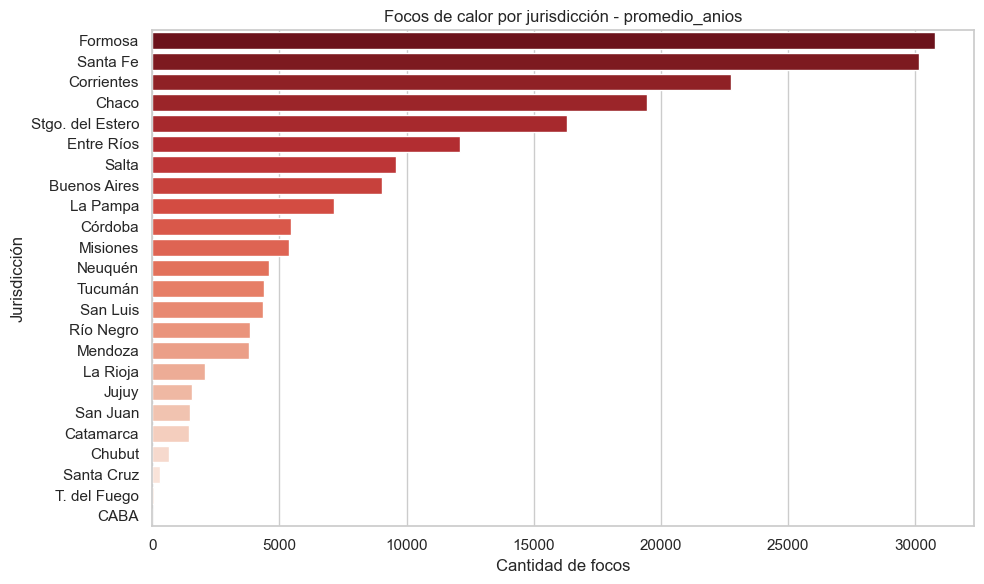

In [5]:
promedio_anios = focos.columns[-1]
focos_ultimo = focos[["jurisdicción", promedio_anios]].sort_values(by=promedio_anios, ascending=False)

plt.figure()
sns.barplot(data=focos_ultimo, x=promedio_anios, y="jurisdicción", palette="Reds_r")
plt.title(f"Focos de calor por jurisdicción - {promedio_anios}")
plt.xlabel("Cantidad de focos")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()


###  Evolución temporal de focos de calor a nivel nacional

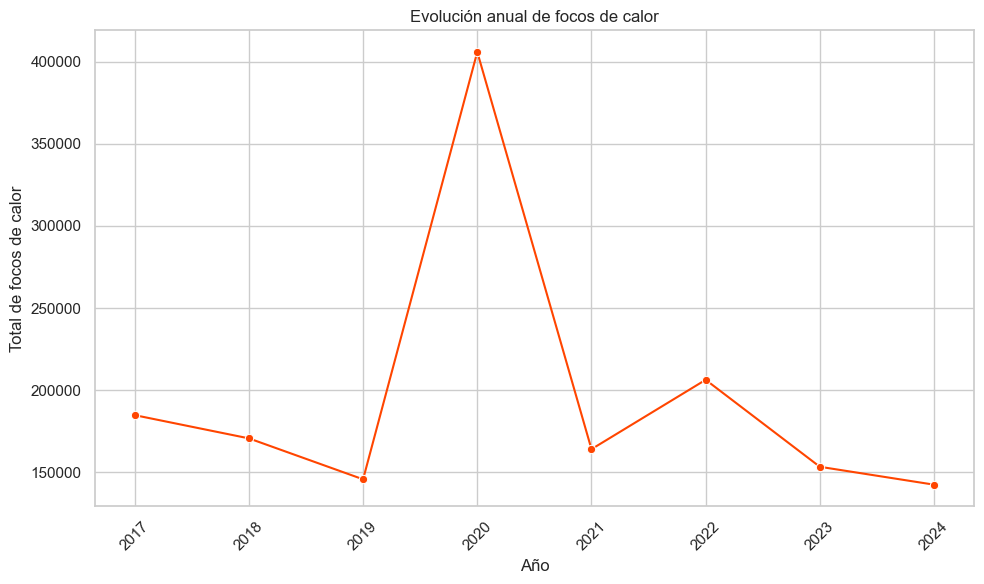

In [6]:
# Excluimos la columna "jurisdicción" y la última columna del DataFrame
columnas_a_sumar = focos.columns[1:-1]  # Seleccionamos todas las columnas excepto la primera ("jurisdicción") y la última("Promedio")

# Sumamos únicamente las columnas numéricas de los años
focos_anual = (
    focos[columnas_a_sumar]  # Nos quedamos solo con las columnas correspondientes a años
    .sum()  # Sumamos los valores por cada año
    .reset_index()  # Convertimos el índice a columna para reestructurar el DataFrame
)

# Renombramos las columnas
focos_anual.columns = ["año", "total_focos"]

# Quitamos el prefijo "año_" en caso de que los nombres contengan este prefijo
focos_anual["año"] = focos_anual["año"].str.replace("año_", "").astype(int)

# Visualizamos los resultados con Seaborn
plt.figure()
sns.lineplot(data=focos_anual, x="año", y="total_focos", marker="o", color="orangered")
plt.title("Evolución anual de focos de calor")
plt.xlabel("Año")
plt.ylabel("Total de focos de calor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Superficie afectada promedio por jurisdicción

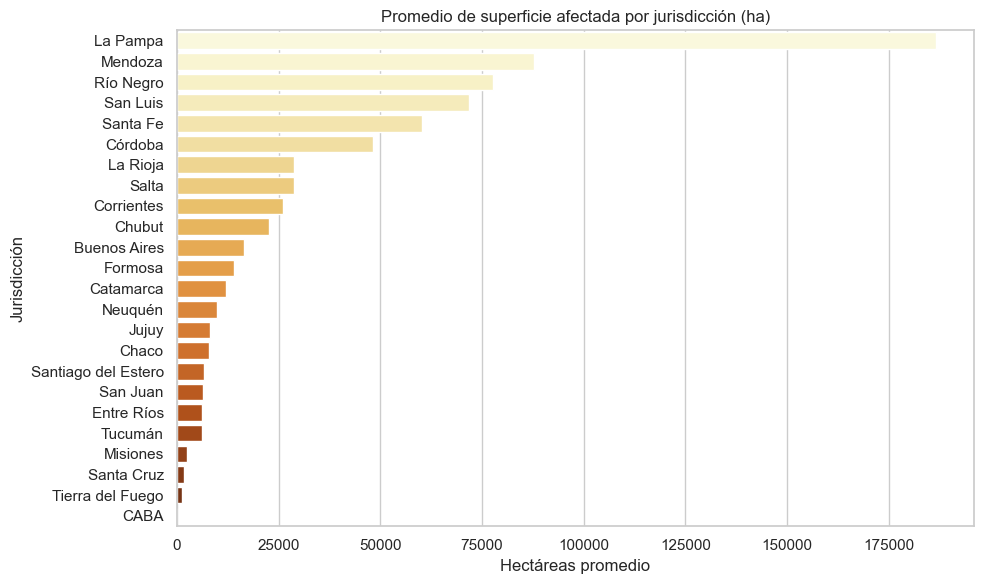

In [7]:
# Verificamos las columnas
columnas_a_promediar = superficie_abs.columns[1:-1]  # Excluimos la primera columna (jurisdicción) y la última (promedio)

# Calculamos de nuevo el promedio de superficie afectada por jurisdicción (si es necesario)
superficie_abs["promedio"] = superficie_abs[columnas_a_promediar].mean(axis=1)

# Seleccionamos la columna 'promedio' para el gráfico
superficie_media = (
    superficie_abs.set_index("jurisdicción")["promedio"]  # Usamos la columna promedio
    .sort_values(ascending=False)  # Ordenamos de mayor a menor
)

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x=superficie_media.values, y=superficie_media.index, palette="YlOrBr")
plt.title("Promedio de superficie afectada por jurisdicción (ha)")
plt.xlabel("Hectáreas promedio")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()

### Relación entre densidad poblacional y superficie afectada (último año)

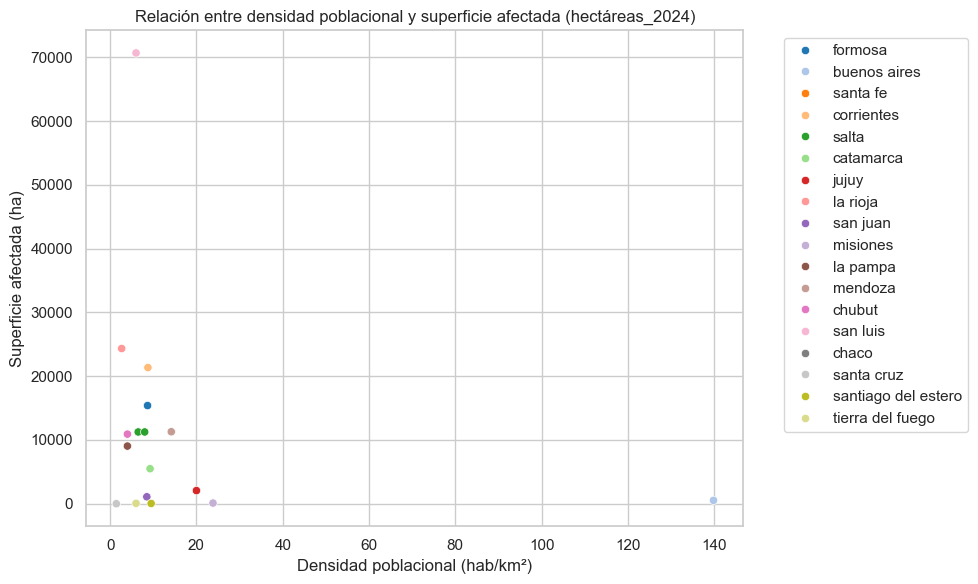

In [8]:
# (Si la columna original se llama 'provincia' en poblacion)
poblacion["jurisdicción"] = poblacion["provincia"].str.strip().str.lower()
superficie_abs["jurisdicción"] = superficie_abs["jurisdicción"].str.strip().str.lower()

df_comb = pd.merge(
    poblacion, 
    superficie_abs[["jurisdicción", superficie_abs.columns[-4]]], 
    on="jurisdicción", 
    how="inner"
)

plt.figure()
sns.scatterplot(data=df_comb, x="prom_densidad_hab_km2", y=superficie_abs.columns[-4], hue="jurisdicción", palette="tab20")
plt.title(f"Relación entre densidad poblacional y superficie afectada ({superficie_abs.columns[-4]})")
plt.xlabel("Densidad poblacional (hab/km²)")
plt.ylabel("Superficie afectada (ha)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Correlaciones profundas
* Se busca entender si hay relación estadística entre:

    🔥 Focos de calor

    🧯 Incendios reportados

    🌾 Superficie afectada

    👥 Densidad poblacional

### Preparacion de la tabla

In [9]:
cols_focos = [c for c in focos.columns if c.startswith("año_") or c.isdigit()]
cols_inc = [c for c in incendios.columns if c.startswith("año_") or c.isdigit()]
cols_sup = [c for c in superficie_abs.columns if c.startswith("hectáreas_") or c.isdigit()]
cols_focos_mes = [c for c in focos_mes.columns if c in orden_meses]
cols_inc_mes = [c for c in incendios_mes.columns if c.startswith("año_") or c.isdigit()]

In [10]:
focos["focos_prom"] = focos[cols_focos].mean(axis=1)
incendios["incendios_prom"] = incendios[cols_inc].mean(axis=1)
superficie_abs = superficie_abs.rename(columns={"promedio": "superficie_afectada_prom"})


### Normalizacion de clave jurisdiccion

In [11]:
# Diccionario para normalizar nombres de jurisdicciones
normalizacion_jurisdicciones = {
    "cordoba": "córdoba",
    "entre rios": "entre ríos",
    "neuquen": "neuquén",
    "rio negro": "río negro",
    "tucuman": "tucumán",
    "stgo. del estero": "santiago del estero",
    "t. del fuego": "tierra del fuego"
}


In [12]:
def normalizar_jurisdicciones(df):
    df["jurisdicción"] = df["jurisdicción"].str.strip().str.lower()
    df["jurisdicción"] = df["jurisdicción"].replace(normalizacion_jurisdicciones)
    return df

# Aplicar a todos los DataFrames
focos = normalizar_jurisdicciones(focos)
incendios = normalizar_jurisdicciones(incendios)
superficie_abs = normalizar_jurisdicciones(superficie_abs)
poblacion = normalizar_jurisdicciones(poblacion)


In [13]:
df_corr = focos[["jurisdicción", "focos_prom"]].merge(
    incendios[["jurisdicción", "incendios_prom"]], on="jurisdicción", how="inner"
).merge(
    superficie_abs[["jurisdicción", "superficie_afectada_prom"]], on="jurisdicción", how="inner"
).merge(
    poblacion[["jurisdicción", "prom_densidad_hab_km2"]], on="jurisdicción", how="left"
)
# Eliminar filas con NaN en variables críticas:
df_corr = df_corr.dropna(subset=["focos_prom", "incendios_prom", "superficie_afectada_prom", "prom_densidad_hab_km2"])


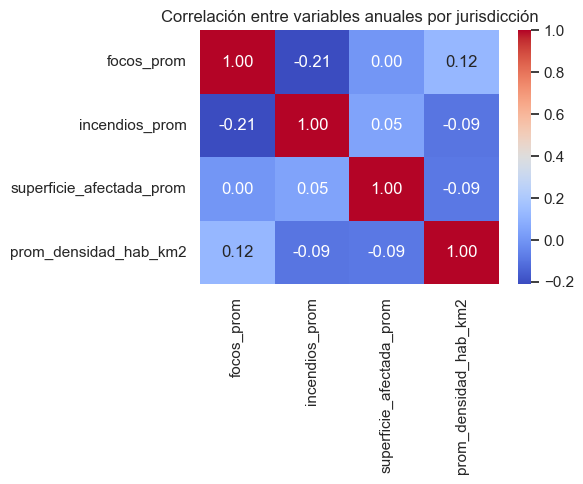

In [14]:
corr_mat = df_corr.drop(columns="jurisdicción").corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables anuales por jurisdicción")
plt.tight_layout()
plt.show()


In [15]:
# Melt con columnas ya filtradas por año (definidas antes)
focos_largo = focos.melt(id_vars="jurisdicción", value_vars=cols_focos, var_name="año", value_name="cantidad_focos")
focos_largo["año"] = focos_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))

incendios_largo = incendios.melt(id_vars="jurisdicción", value_vars=cols_inc, var_name="año", value_name="cantidad_incendios")
incendios_largo["año"] = incendios_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))

superficie_largo = superficie_abs.melt(id_vars="jurisdicción", value_vars=cols_sup, var_name="año", value_name="superficie_afectada")
superficie_largo["año"] = superficie_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))


In [16]:
df_ja = focos_largo.merge(incendios_largo, on=["jurisdicción","año"], how="inner") \
                   .merge(superficie_largo, on=["jurisdicción","año"], how="inner") \
                   .merge(poblacion[["jurisdicción","prom_densidad_hab_km2"]], on="jurisdicción", how="left")
df_ja = df_ja.dropna(subset=["cantidad_focos","cantidad_incendios","superficie_afectada","prom_densidad_hab_km2"])


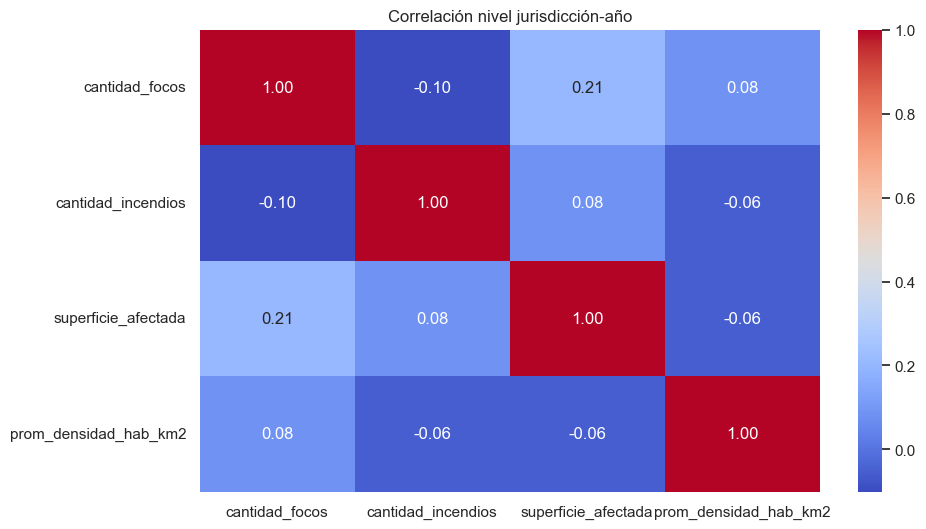

In [17]:
corr_mat2 = df_ja[["cantidad_focos","cantidad_incendios","superficie_afectada","prom_densidad_hab_km2"]].corr()
sns.heatmap(corr_mat2, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación nivel jurisdicción-año")
plt.show()


# Visualización estacional de incendios
* Objetivo: detectar meses con mayor promedio de incendios y patrones de estacionalidad.

### Enfoque Estacional Nacional

In [18]:
#Convertir a formato largo
df_inc_nac = incendios_mes.melt(id_vars="mes", value_vars=cols_inc_mes, var_name="año", value_name="cantidad")

#Normalizar mes

df_inc_nac["mes"] = df_inc_nac["mes"].str.lower()

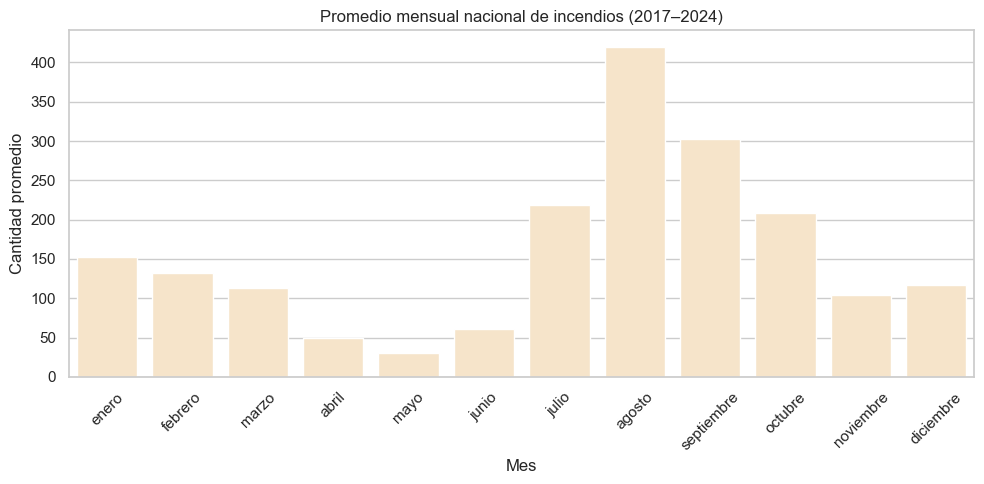

In [19]:
#Promedio mensual nacional
prom_nacional = df_inc_nac.groupby("mes")["cantidad"].mean().reindex(orden_meses).reset_index()

#Grafico de barras
plt.figure(figsize=(10, 5))
sns.barplot(data=prom_nacional, x="mes", y="cantidad")
plt.title("Promedio mensual nacional de incendios (2017–2024)")
plt.xticks(rotation=45)
plt.ylabel("Cantidad promedio")
plt.xlabel("Mes")
plt.tight_layout()
plt.show()

### Enfoque Estacional Provincial (Proxy)

In [20]:
#Convertir a formato largo
df_focos_largo = focos_mes.melt(id_vars=["jurisdicción","año"], value_vars=cols_focos_mes,var_name="mes",value_name="cantidad_focos")

#Normalizar nombres de provincias 
df_focos_largo = normalizar_jurisdicciones(df_focos_largo)

df_focos_largo["mes"] = df_focos_largo["mes"].str.lower()

In [21]:
# Promedio mensual por jurisdicción
prom_focos_jur = (
    df_focos_largo.groupby(["jurisdicción", "mes"])["cantidad_focos"]
    .mean()
    .reset_index()
)

# Ordenar meses para visualización
prom_focos_jur["mes"] = pd.Categorical(prom_focos_jur["mes"], categories=orden_meses, ordered=True)
prom_focos_jur = prom_focos_jur.sort_values(["jurisdicción", "mes"])


### ! Ayuda de interpretacion: Por no contar con el dataset apropiado ( incendios por mes por jurisdiccion) y teniendo en cuenta que la correlacion, de incendios con focos es baja aprox -0.20, este analisis debe ser tratado con cuidado, ya que los valores pueden no ser representativos y solo sirven como una aproximacion.

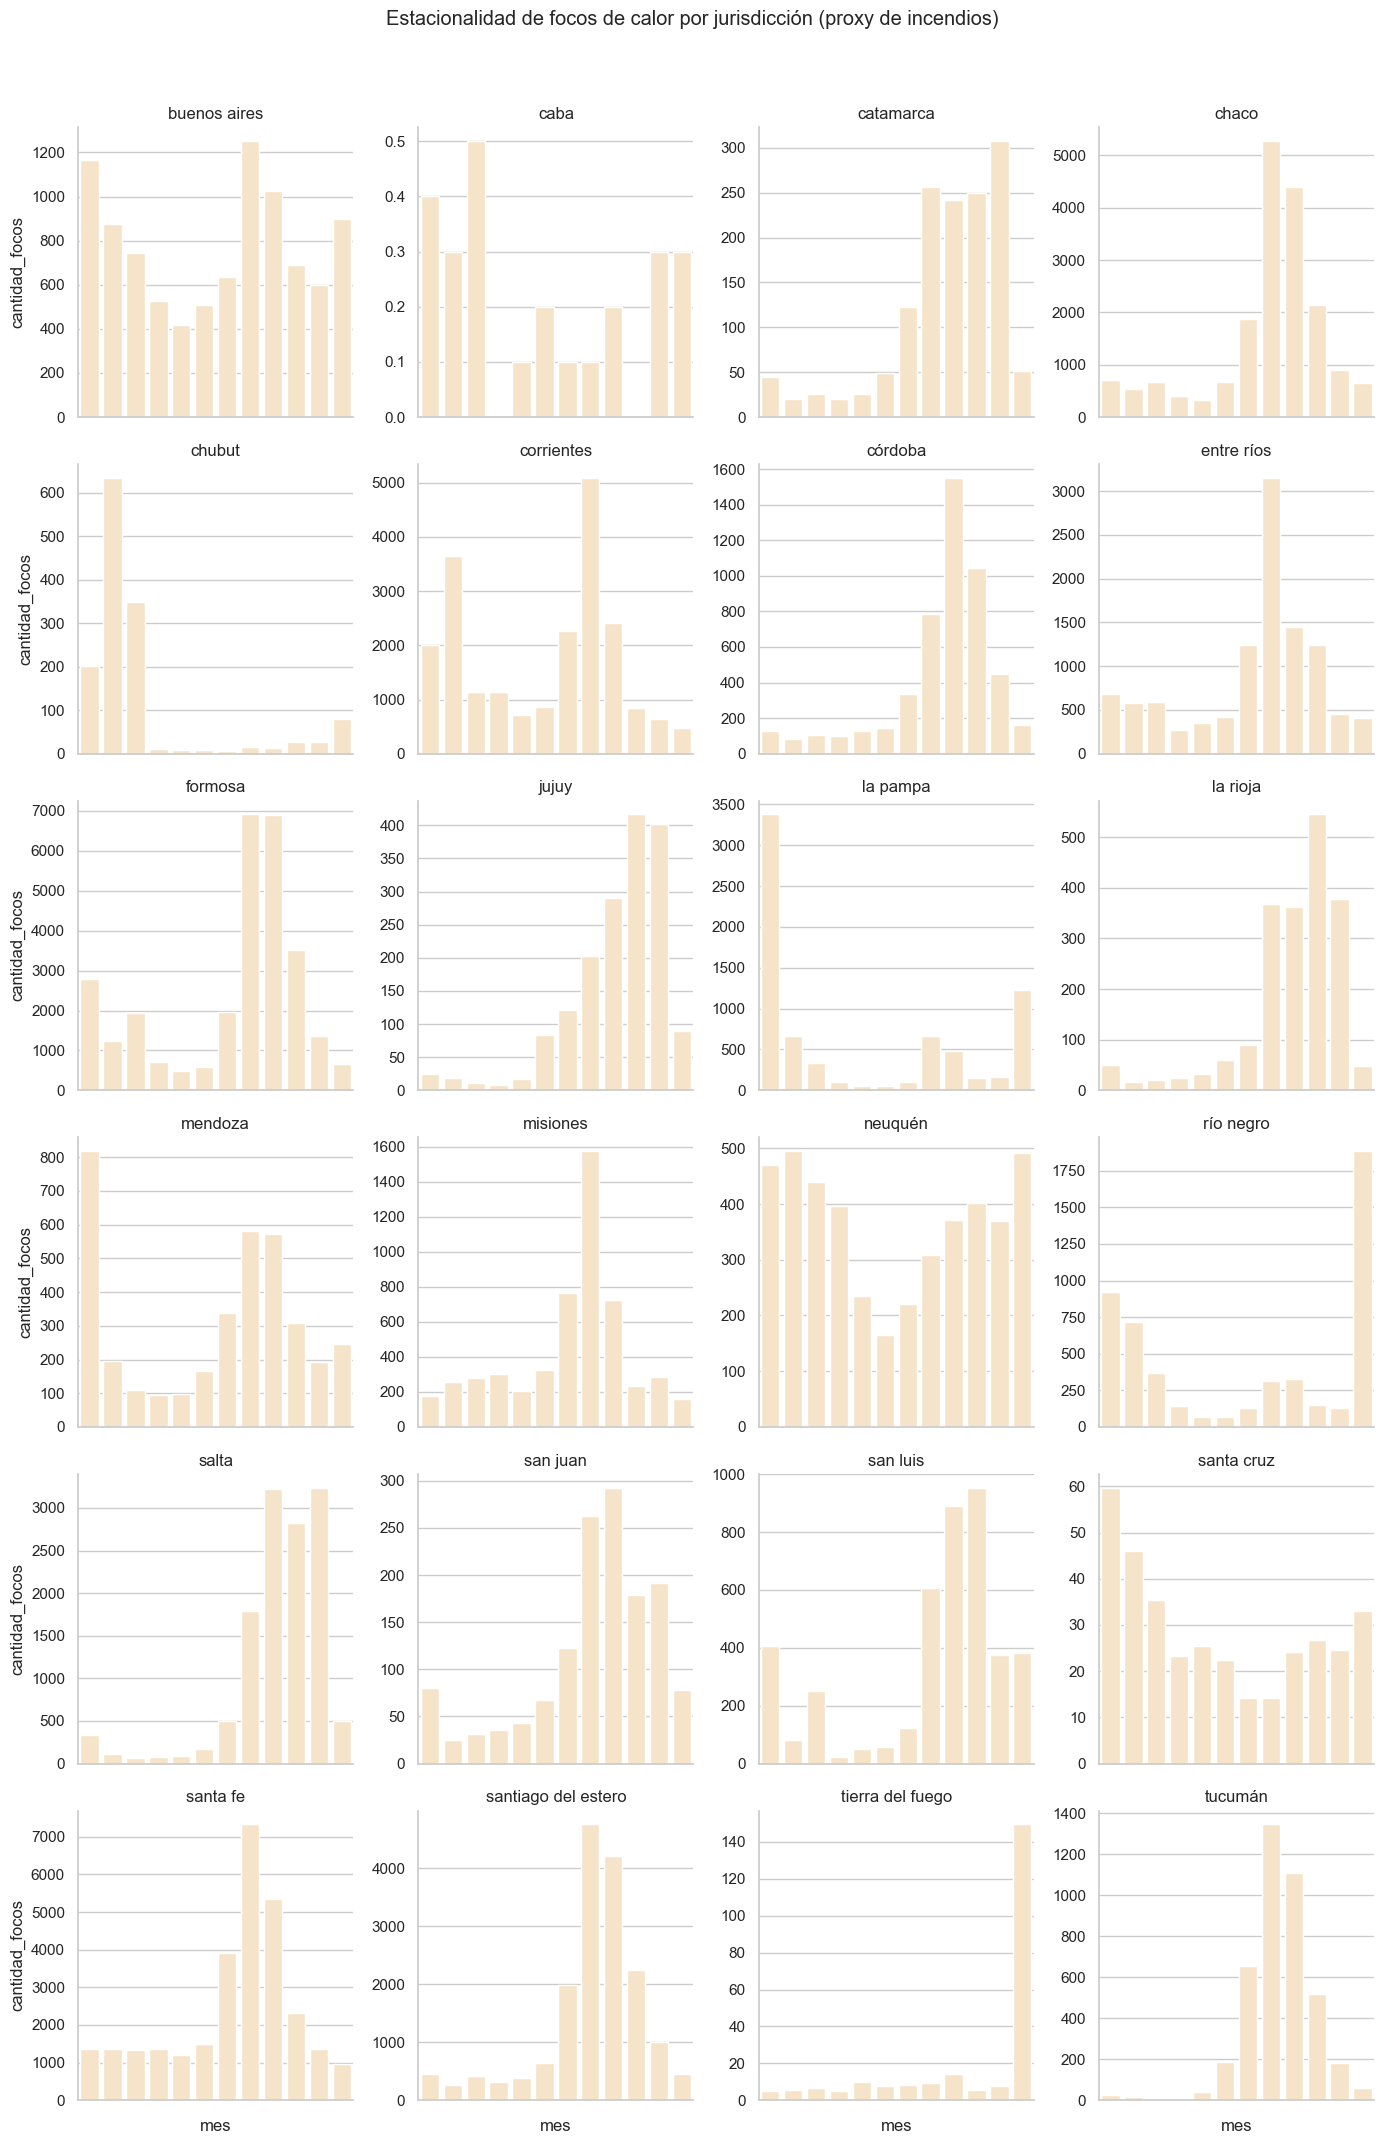

In [22]:
# Gráfico múltiple: estacionalidad por provincia (proxy)
g = sns.FacetGrid(prom_focos_jur, col="jurisdicción", col_wrap=4, height=3.5, sharey=False)
g.map(sns.barplot, "mes", "cantidad_focos", order=orden_meses)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.figure.suptitle("Estacionalidad de focos de calor por jurisdicción (proxy de incendios)", y=1.02)
plt.tight_layout()
plt.show()


In [23]:
# Mes con mayor promedio por jurisdicción (10 más altos)
mes_max_focos = (
    prom_focos_jur.loc[prom_focos_jur.groupby("jurisdicción")["cantidad_focos"].idxmax()]
    .sort_values("cantidad_focos", ascending=False)
    .reset_index(drop=True)
)

mes_max_focos.rename(columns={"mes": "mes_pico", "cantidad_focos": "focos_promedio_max"}, inplace=True)
mes_max_focos.head(10)


,jurisdicción,mes_pico,focos_promedio_max
0,santa fe,agosto,7333.4
1,formosa,agosto,6913.9
2,chaco,agosto,5270.8
3,corrientes,agosto,5093.0
4,santiago del estero,agosto,4752.9
5,la pampa,enero,3378.0
6,salta,noviembre,3237.7
7,entre ríos,agosto,3152.8
8,río negro,diciembre,1884.0
9,misiones,agosto,1574.7


In [24]:
# Obtener top 3 meses con más focos promedio por provincia
top3_focos = (
    prom_focos_jur.sort_values(["jurisdicción", "cantidad_focos"], ascending=[True, False])
    .groupby("jurisdicción")
    .head(3)
    .reset_index(drop=True)
)

# Mostrar ejemplo
top3_focos.head(9)


,jurisdicción,mes,cantidad_focos
0,buenos aires,agosto,1251.4
1,buenos aires,enero,1164.4
2,buenos aires,septiembre,1026.8
3,caba,marzo,0.5
4,caba,enero,0.4
5,caba,febrero,0.3
6,catamarca,noviembre,307.4
7,catamarca,agosto,256.6
8,catamarca,octubre,249.5


# Preparacion Para Machine Learning

In [25]:
df_ml = focos_largo.merge(incendios_largo, on=["jurisdicción", "año"], how="inner") \
                   .merge(superficie_largo, on=["jurisdicción", "año"], how="inner") \
                   .merge(poblacion[["jurisdicción", "prom_densidad_hab_km2"]], on="jurisdicción", how="left")


Feaute engineering: orden y lags

In [26]:
df_ml = df_ml.sort_values(["jurisdicción", "año"])

df_ml["focos_lag1"] = df_ml.groupby("jurisdicción")["cantidad_focos"].shift(1)
df_ml["incendios_lag1"] = df_ml.groupby("jurisdicción")["cantidad_incendios"].shift(1)

Limpieza: elimina NAs generados por lags

In [27]:
df_ml = df_ml.dropna(subset=["focos_lag1", "incendios_lag1"]).reset_index(drop=True)

In [28]:

# %% [markdown]
# ## 2. PREPARACIÓN DE DATOS

# %%
# Verificar estructura del dataset
print("📊 INFORMACIÓN DEL DATASET")
print(f"Forma del dataset: {df_ml.shape}")
print(f"Columnas: {list(df_ml.columns)}")
print(f"Rango de años: {df_ml['año'].min()} - {df_ml['año'].max()}")
print(f"Jurisdicciones únicas: {df_ml['jurisdicción'].nunique()}")

# Verificar valores faltantes
print("\n🔍 VALORES FALTANTES:")
print(df_ml.isnull().sum())

# Estadísticas descriptivas
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
df_ml.describe()

📊 INFORMACIÓN DEL DATASET
Forma del dataset: (174, 8)
Columnas: ['jurisdicción', 'año', 'cantidad_focos', 'cantidad_incendios', 'superficie_afectada', 'prom_densidad_hab_km2', 'focos_lag1', 'incendios_lag1']
Rango de años: 2017 - 2024
Jurisdicciones únicas: 24

🔍 VALORES FALTANTES:
jurisdicción             0
año                      0
cantidad_focos           0
cantidad_incendios       0
superficie_afectada      6
prom_densidad_hab_km2    7
focos_lag1               0
incendios_lag1           0
dtype: int64

📈 ESTADÍSTICAS DESCRIPTIVAS:


,año,cantidad_focos,cantidad_incendios,superficie_afectada,prom_densidad_hab_km2,focos_lag1,incendios_lag1
count,174.000000,174.000000,174.000000,168.000000,167.000000,174.00000,174.000000
mean,2021.011494,8244.396552,89.132184,28158.682857,16.899165,8563.54023,78.603448
std,2.008619,11700.916056,113.108214,65963.216824,27.368959,11799.35348,90.510998
min,2017.000000,0.000000,0.000000,0.000000,1.428571,0.00000,0.000000
25%,2019.000000,1278.250000,12.250000,1983.702500,6.000000,1355.75000,12.250000
50%,2021.000000,3990.000000,49.000000,8203.500000,8.500000,4545.50000,45.000000
75%,2023.000000,10518.250000,121.000000,29660.750000,19.166667,10713.25000,109.000000
max,2024.000000,78737.000000,773.000000,704125.000000,139.818182,78737.00000,413.000000



# Modelo 1
### Random Forest - Clasificacion de riesgo

In [29]:
# %% [markdown]
# ## 3. MODELO 1: RANDOM FOREST - CLASIFICACIÓN DE RIESGO
# %%
def crear_variable_riesgo(df, col_target='cantidad_incendios'):
    """
    Crea variable categórica de riesgo basada en percentiles
    """
    df_temp = df.copy()
    
    # Calcular percentiles
    p33 = df_temp[col_target].quantile(0.33)
    p66 = df_temp[col_target].quantile(0.66)
    
    # Crear categorías de riesgo
    def categorizar_riesgo(valor):
        if valor <= p33:
            return 'Bajo'
        elif valor <= p66:
            return 'Medio'
        else:
            return 'Alto'
    
    df_temp['riesgo_categoria'] = df_temp[col_target].apply(categorizar_riesgo)
    
    print(f"📊 DISTRIBUCIÓN DE RIESGO:")
    print(df_temp['riesgo_categoria'].value_counts())
    print(f"\n🎯 Umbrales: Bajo ≤ {p33:.2f}, Medio ≤ {p66:.2f}, Alto > {p66:.2f}")
    
    return df_temp

In [30]:
# Crear variable de riesgo
df_modelo1 = crear_variable_riesgo(df_ml, 'cantidad_incendios')

📊 DISTRIBUCIÓN DE RIESGO:
riesgo_categoria
Bajo     59
Alto     59
Medio    56
Name: count, dtype: int64

🎯 Umbrales: Bajo ≤ 22.00, Medio ≤ 82.90, Alto > 82.90


In [31]:

# %%
def entrenar_random_forest_clasificacion(df):
    """
    Entrena modelo Random Forest para clasificación de riesgo
    """
    print("🌲 ENTRENANDO RANDOM FOREST - CLASIFICACIÓN")
    
    # Preparar variables
    features = ['cantidad_focos', 'focos_lag1', 'incendios_lag1', 'prom_densidad_hab_km2']
    
    # Verificar que las columnas existan
    features_disponibles = [f for f in features if f in df.columns]
    print(f"Features disponibles: {features_disponibles}")
    
    X = df[features_disponibles].fillna(0)
    y = df['riesgo_categoria']
    
    # Codificar variable objetivo
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Entrenar modelo
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    )
    
    rf_classifier.fit(X_train, y_train)
    
    # Predicciones
    y_pred = rf_classifier.predict(X_test)
    
    # Métricas
    print("\n📊 RESULTADOS DEL MODELO:")
    print(f"Accuracy: {rf_classifier.score(X_test, y_test):.4f}")
    print("\n📋 REPORTE DE CLASIFICACIÓN:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Importancia de features
    feature_importance = pd.DataFrame({
        'feature': features_disponibles,
        'importance': rf_classifier.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 IMPORTANCIA DE VARIABLES:")
    print(feature_importance)
    
    # Visualización
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Matriz de confusión
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matriz de Confusión')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    
    # Subplot 2: Importancia de features
    plt.subplot(1, 2, 2)
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Importancia de Variables')
    plt.xlabel('Importancia')
    
    plt.tight_layout()
    plt.show()
    
    return rf_classifier, le, feature_importance

🌲 ENTRENANDO RANDOM FOREST - CLASIFICACIÓN
Features disponibles: ['cantidad_focos', 'focos_lag1', 'incendios_lag1', 'prom_densidad_hab_km2']

📊 RESULTADOS DEL MODELO:
Accuracy: 0.5714

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Alto       0.70      0.58      0.64        12
        Bajo       0.58      0.58      0.58        12
       Medio       0.46      0.55      0.50        11

    accuracy                           0.57        35
   macro avg       0.58      0.57      0.57        35
weighted avg       0.59      0.57      0.58        35


🎯 IMPORTANCIA DE VARIABLES:
                 feature  importance
2         incendios_lag1    0.442737
0         cantidad_focos    0.213156
1             focos_lag1    0.184501
3  prom_densidad_hab_km2    0.159606


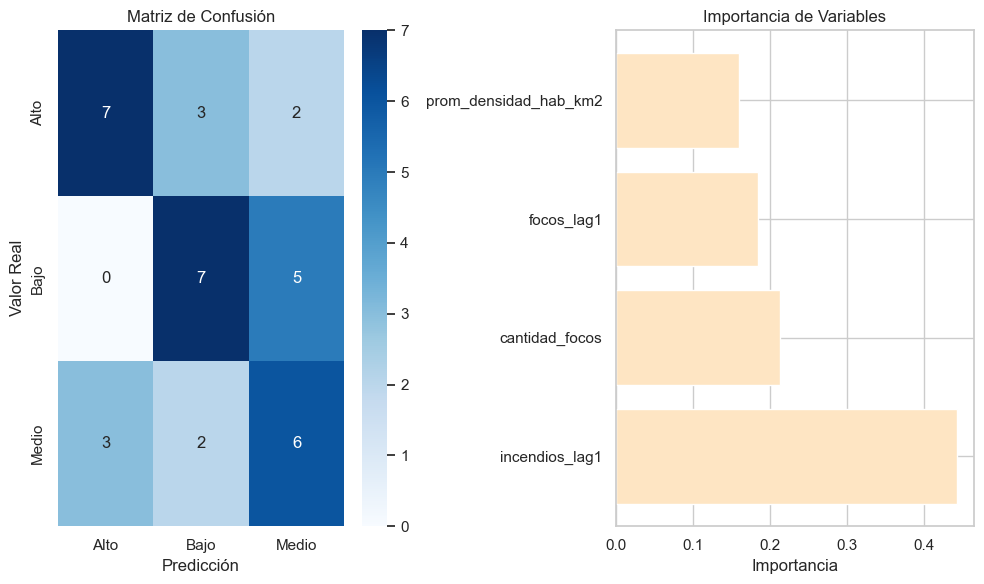

In [32]:

# Entrenar modelo 1
modelo_rf, label_encoder, importancia_rf = entrenar_random_forest_clasificacion(df_modelo1)

# Modelo 2
### XGBoost - Regressor superficie afectada

In [33]:
# %% [markdown]
# ## 4. MODELO 2: XGBOOST - REGRESIÓN SUPERFICIE AFECTADA CON SMOTE-R

# %%
def analizar_datos_superficie(df, target_col='superficie_afectada'):
    """
    Analiza la calidad de los datos para el modelo de superficie
    """
    print("🔍 ANÁLISIS DE DATOS PARA SUPERFICIE AFECTADA")
    print("=" * 60)
    
    # Datos disponibles
    datos_completos = df.dropna(subset=[target_col])
    print(f"📊 Total de registros: {len(df)}")
    print(f"📊 Registros con superficie disponible: {len(datos_completos)}")
    print(f"📊 Porcentaje de datos disponibles: {len(datos_completos)/len(df)*100:.1f}%")
    
    if len(datos_completos) < 50:
        print("⚠️  ADVERTENCIA: Pocos datos disponibles para entrenamiento robusto")
    
    # Análisis de distribución
    print(f"\n📈 ESTADÍSTICAS DE SUPERFICIE AFECTADA:")
    print(f"• Mínimo: {datos_completos[target_col].min():.2f} ha")
    print(f"• Máximo: {datos_completos[target_col].max():.2f} ha")
    print(f"• Media: {datos_completos[target_col].mean():.2f} ha")
    print(f"• Mediana: {datos_completos[target_col].median():.2f} ha")
    print(f"• Desviación estándar: {datos_completos[target_col].std():.2f} ha")
    print(f"• Skewness: {datos_completos[target_col].skew():.2f}")
    
    # Detección de outliers
    Q1 = datos_completos[target_col].quantile(0.25)
    Q3 = datos_completos[target_col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_lower = Q1 - 1.5 * IQR
    outliers_upper = Q3 + 1.5 * IQR
    
    outliers = datos_completos[
        (datos_completos[target_col] < outliers_lower) | 
        (datos_completos[target_col] > outliers_upper)
    ]
    
    print(f"\n🎯 ANÁLISIS DE OUTLIERS:")
    print(f"• Límite inferior: {outliers_lower:.2f} ha")
    print(f"• Límite superior: {outliers_upper:.2f} ha")
    print(f"• Outliers detectados: {len(outliers)} ({len(outliers)/len(datos_completos)*100:.1f}%)")
    
    # Análisis de rareza de valores (importante para SMOTE-R)
    print(f"\n🎯 ANÁLISIS DE RAREZA DE VALORES:")
    valores_percentiles = [10, 25, 50, 75, 90, 95, 99]
    for p in valores_percentiles:
        valor = datos_completos[target_col].quantile(p/100)
        print(f"• Percentil {p}%: {valor:.2f} ha")
    
    # Visualización
    plt.figure(figsize=(20, 10))
    
    # Histograma
    plt.subplot(2, 4, 1)
    plt.hist(datos_completos[target_col], bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(datos_completos[target_col].mean(), color='red', linestyle='--', label='Media')
    plt.axvline(datos_completos[target_col].median(), color='green', linestyle='--', label='Mediana')
    plt.xlabel('Superficie Afectada (ha)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución Original de Superficie Afectada')
    plt.legend()
    plt.yscale('log')
    
    # Box plot
    plt.subplot(2, 4, 2)
    plt.boxplot(datos_completos[target_col])
    plt.ylabel('Superficie Afectada (ha)')
    plt.title('Box Plot - Detección de Outliers')
    plt.yscale('log')
    
    # Tendencia temporal
    plt.subplot(2, 4, 3)
    superficie_anual = datos_completos.groupby('año')[target_col].mean()
    plt.plot(superficie_anual.index, superficie_anual.values, marker='o')
    plt.xlabel('Año')
    plt.ylabel('Superficie Promedio (ha)')
    plt.title('Tendencia Temporal')
    plt.xticks(rotation=45)
    
    # Q-Q plot para normalidad
    plt.subplot(2, 4, 4)
    from scipy import stats
    stats.probplot(datos_completos[target_col], dist="norm", plot=plt)
    plt.title('Q-Q Plot - Normalidad')
    
    # Distribución log-transformada
    plt.subplot(2, 4, 5)
    log_values = np.log1p(datos_completos[target_col])
    plt.hist(log_values, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Log(Superficie + 1)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución Log-transformada')
    
    # Correlación con features numéricas
    plt.subplot(2, 4, 6)
    numeric_cols = datos_completos.select_dtypes(include=[np.number]).columns
    correlation_with_target = datos_completos[numeric_cols].corr()[target_col].sort_values(ascending=False)
    correlation_with_target = correlation_with_target[correlation_with_target.index != target_col]
    
    if len(correlation_with_target) > 0:
        plt.barh(range(len(correlation_with_target)), correlation_with_target.values)
        plt.yticks(range(len(correlation_with_target)), correlation_with_target.index)
        plt.xlabel('Correlación con Superficie')
        plt.title('Correlaciones con Target')
    
    # Distribución por percentiles
    plt.subplot(2, 4, 7)
    percentiles = np.arange(0, 101, 5)
    valores_percentiles = [datos_completos[target_col].quantile(p/100) for p in percentiles]
    plt.plot(percentiles, valores_percentiles, marker='o')
    plt.xlabel('Percentil')
    plt.ylabel('Valor (ha)')
    plt.title('Distribución por Percentiles')
    plt.yscale('log')
    
    # Densidad acumulativa
    plt.subplot(2, 4, 8)
    valores_ordenados = np.sort(datos_completos[target_col])
    y_values = np.arange(1, len(valores_ordenados) + 1) / len(valores_ordenados)
    plt.plot(valores_ordenados, y_values)
    plt.xlabel('Superficie Afectada (ha)')
    plt.ylabel('Probabilidad Acumulativa')
    plt.title('Función de Distribución Acumulativa')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return datos_completos

In [34]:
#%%
def aplicar_smote_r(X, y, target_col='superficie_afectada', metodo='extremos'):
    """
    Aplica SMOTE-R (SMOGN) para balancear el dataset de regresión
    
    Parámetros:
    - X: features
    - y: target variable
    - target_col: nombre de la columna target
    - metodo: 'extremos' o 'percentiles'
    """
    print(f"\n🔄 APLICANDO SMOTE-R - MÉTODO: {metodo.upper()}")
    print("=" * 60)
    
    # Crear dataframe combinado para SMOGN
    data_combined = X.copy()
    data_combined[target_col] = y
    
    print(f"📊 Datos originales: {len(data_combined)} muestras")
    
    # Análisis de la distribución original
    print(f"\n📈 DISTRIBUCIÓN ORIGINAL:")
    q25, q50, q75 = np.percentile(y, [25, 50, 75])
    q90, q95, q99 = np.percentile(y, [90, 95, 99])
    print(f"• Q25: {q25:.2f}, Q50: {q50:.2f}, Q75: {q75:.2f}")
    print(f"• Q90: {q90:.2f}, Q95: {q95:.2f}, Q99: {q99:.2f}")
    
    # Definir valores raros según el método elegido
    if metodo == 'extremos':
        # Método 1: Valores extremos (muy altos y muy bajos)
        raro_bajo = np.percentile(y, 10)   # 10% más bajo
        raro_alto = np.percentile(y, 90)   # 10% más alto
        
        rel_thres = 0.8  # Threshold para considerar relevancia
        rel_method = 'auto'
        
        print(f"🎯 MÉTODO EXTREMOS:")
        print(f"• Valores raros bajos: < {raro_bajo:.2f}")
        print(f"• Valores raros altos: > {raro_alto:.2f}")
        
    else:  # metodo == 'percentiles'
        # Método 2: Basado en percentiles específicos
        raro_bajo = np.percentile(y, 5)    # 5% más bajo
        raro_alto = np.percentile(y, 95)   # 5% más alto
        
        rel_thres = 0.9  # Threshold más estricto
        rel_method = 'manual'
        
        print(f"🎯 MÉTODO PERCENTILES:")
        print(f"• Valores raros bajos: < {raro_bajo:.2f}")
        print(f"• Valores raros altos: > {raro_alto:.2f}")
    
    try:
        # Aplicar SMOGN
        if metodo == 'extremos':

            # Calcular valores raros manualmente
            raro_bajo = np.percentile(y, 10)
            raro_alto = np.percentile(y, 90)
            n_raros = ((y <= raro_bajo) | (y >= raro_alto)).sum()

            print(f"🔍 Valores raros detectados: {n_raros}")

            if n_raros < 3:
                print("❌ No hay suficientes puntos raros para aplicar SMOGN con k=5")
                return X, y, False

            # 🔧 Resetear índice para evitar errores internos en smogn
            data_combined = data_combined.reset_index(drop=True)

            # Aplicar SMOGN con k reducido
            k_real = min(5, n_raros - 1)
            print(f"🧠 Usando k = {k_real} para SMOGN")

            data_smogn = smogn.smoter(
                data=data_combined,
                y=target_col,
                k=k_real,
                pert=0.02,
                samp_method='extreme',
                drop_na_col=True,
                drop_na_row=True,
                replace=False
            )

            print("sali if")
        else:
            print("Percentiles")
            # Configuración para percentiles
            # Definir manualmente las regiones de relevancia
            rel_coef = np.array([[raro_bajo, 1, 0],     # valores bajos raros
                                [q50, 0, 0],            # valores normales
                                [raro_alto, 1, 0]])     # valores altos raros
            
            data_smogn = smogn.smoter(
                data=data_combined,
                y=target_col,
                k=5,
                pert=0.05,
                samp_method='balance',
                rel_thres=rel_thres,
                rel_method='manual',
                rel_xtrms_type='both',
                rel_coef=rel_coef,
                drop_na_col=True,
                drop_na_row=True,
                replace=False
            )
        
        print(f"✅ SMOTE-R aplicado exitosamente")
        print(f"📊 Datos después de SMOTE-R: {len(data_smogn)} muestras")
        print(f"📈 Incremento: {len(data_smogn) - len(data_combined)} muestras sintéticas")
    
    except Exception as e:
        print(f"❌ Error aplicando SMOTE-R: {str(e)}")
        traceback.print_exc()  # Mostrará el stack completo
        print("🔄 Usando dataset original sin SMOTE-R")
        return X, y, False
    
    # Separar features y target
    X_smogn = data_smogn.drop(columns=[target_col])
    y_smogn = data_smogn[target_col]

    # Reiniciar índices para evitar errores en .iloc
    X_smogn = X_smogn.reset_index(drop=True)
    y_smogn = y_smogn.reset_index(drop=True)
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    
    # Análisis de la distribución después de SMOTE-R
    print(f"\n📈 DISTRIBUCIÓN DESPUÉS DE SMOTE-R:")
    q25_new, q50_new, q75_new = np.percentile(y_smogn, [25, 50, 75])
    q90_new, q95_new, q99_new = np.percentile(y_smogn, [90, 95, 99])
    print(f"• Q25: {q25_new:.2f}, Q50: {q50_new:.2f}, Q75: {q75_new:.2f}")
    print(f"• Q90: {q90_new:.2f}, Q95: {q95_new:.2f}, Q99: {q99_new:.2f}")
    
    # Comparar distribuciones
    print(f"\n📊 COMPARACIÓN DE DISTRIBUCIONES:")
    print(f"• Media original: {y.mean():.2f} → Nueva: {y_smogn.mean():.2f}")
    print(f"• Std original: {y.std():.2f} → Nueva: {y_smogn.std():.2f}")
    print(f"• Skewness original: {y.skew():.2f} → Nueva: {y_smogn.skew():.2f}")
    
    # Visualización comparativa
    plt.figure(figsize=(20, 8))
    
    # Histograma comparativo
    plt.subplot(2, 4, 1)
    plt.hist(y, bins=30, alpha=0.7, label='Original', density=True)
    plt.hist(y_smogn, bins=30, alpha=0.7, label='Con SMOTE-R', density=True)
    plt.xlabel('Superficie Afectada (ha)')
    plt.ylabel('Densidad')
    plt.title(f'Distribución - {metodo.title()}')
    plt.legend()
    plt.yscale('log')
    
    # Box plot comparativo
    plt.subplot(2, 4, 2)
    data_comp = [y, y_smogn]
    plt.boxplot(data_comp, labels=['Original', 'SMOTE-R'])
    plt.ylabel('Superficie Afectada (ha)')
    plt.title('Box Plot Comparativo')
    plt.yscale('log')
    
    # Distribución acumulativa
    plt.subplot(2, 4, 3)
    y_sorted = np.sort(y)
    y_smogn_sorted = np.sort(y_smogn)
    p_orig = np.arange(1, len(y_sorted) + 1) / len(y_sorted)
    p_smogn = np.arange(1, len(y_smogn_sorted) + 1) / len(y_smogn_sorted)
    
    plt.plot(y_sorted, p_orig, label='Original', alpha=0.8)
    plt.plot(y_smogn_sorted, p_smogn, label='SMOTE-R', alpha=0.8)
    plt.xlabel('Superficie Afectada (ha)')
    plt.ylabel('Probabilidad Acumulativa')
    plt.title('Función de Distribución Acumulativa')
    plt.legend()
    plt.xscale('log')
    
    # Análisis por rangos
    plt.subplot(2, 4, 4)
    ranges = [(0, q25), (q25, q50), (q50, q75), (q75, q90), (q90, np.inf)]
    range_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
    
    counts_orig = []
    counts_smogn = []
    
    for rmin, rmax in ranges:
        count_orig = len(y[(y >= rmin) & (y < rmax)])
        count_smogn = len(y_smogn[(y_smogn >= rmin) & (y_smogn < rmax)])
        counts_orig.append(count_orig)
        counts_smogn.append(count_smogn)
    
    x = np.arange(len(range_labels))
    width = 0.35
    
    plt.bar(x - width/2, counts_orig, width, label='Original', alpha=0.8)
    plt.bar(x + width/2, counts_smogn, width, label='SMOTE-R', alpha=0.8)
    plt.xlabel('Rango de Percentiles')
    plt.ylabel('Cantidad de Muestras')
    plt.title('Distribución por Rangos')
    plt.xticks(x, range_labels)
    plt.legend()
    
    # Scatter plot de muestras sintéticas vs originales
    plt.subplot(2, 4, 5)

    # Definir cantidad original
    n_original = len(X)

    plt.scatter(X_smogn.iloc[:n_original, 0], y.iloc[:n_original], alpha=0.6, label='Original', s=20)
    if len(X_smogn) > n_original:
        plt.scatter(X_smogn.iloc[n_original:, 0], y_smogn.iloc[n_original:], alpha=0.8, label='Sintético', s=20, marker='^')

    plt.xlabel(X_smogn.columns[0])
    plt.ylabel('Superficie Afectada (ha)')
    plt.title('Muestras Originales vs Sintéticas')
    plt.legend()

    
    # Análisis de densidad por valores extremos
    plt.subplot(2, 4, 6)
    extremos_orig_bajo = len(y[y <= raro_bajo])
    extremos_orig_alto = len(y[y >= raro_alto])
    extremos_smogn_bajo = len(y_smogn[y_smogn <= raro_bajo])
    extremos_smogn_alto = len(y_smogn[y_smogn >= raro_alto])
    
    categories = ['Extremos\nBajos', 'Valores\nNormales', 'Extremos\nAltos']
    orig_counts = [extremos_orig_bajo, 
                   len(y) - extremos_orig_bajo - extremos_orig_alto,
                   extremos_orig_alto]
    smogn_counts = [extremos_smogn_bajo,
                    len(y_smogn) - extremos_smogn_bajo - extremos_smogn_alto,
                    extremos_smogn_alto]
    
    x = np.arange(len(categories))
    plt.bar(x - width/2, orig_counts, width, label='Original', alpha=0.8)
    plt.bar(x + width/2, smogn_counts, width, label='SMOTE-R', alpha=0.8)
    plt.xlabel('Tipo de Valores')
    plt.ylabel('Cantidad')
    plt.title('Distribución de Valores Extremos')
    plt.xticks(x, categories)
    plt.legend()
    
    # Estadísticas descriptivas
    plt.subplot(2, 4, 7)
    stats_orig = [y.min(), q25, y.median(), q75, y.max()]
    stats_smogn = [y_smogn.min(), q25_new, y_smogn.median(), q75_new, y_smogn.max()]
    stat_labels = ['Min', 'Q25', 'Mediana', 'Q75', 'Max']
    
    x = np.arange(len(stat_labels))
    plt.bar(x - width/2, stats_orig, width, label='Original', alpha=0.8)
    plt.bar(x + width/2, stats_smogn, width, label='SMOTE-R', alpha=0.8)
    plt.xlabel('Estadísticas')
    plt.ylabel('Valor (ha)')
    plt.title('Estadísticas Descriptivas')
    plt.xticks(x, stat_labels, rotation=45)
    plt.legend()
    plt.yscale('log')
    
    # Mejora en balanceamiento
    plt.subplot(2, 4, 8)
    # Calcular índice de balanceamiento (coeficiente de variación)
    cv_orig = y.std() / y.mean()
    cv_smogn = y_smogn.std() / y_smogn.mean()
    
    # Calcular entropía de distribución
    def calculate_entropy(values, bins=10):
        hist, _ = np.histogram(values, bins=bins, density=True)
        hist = hist[hist > 0]  # Evitar log(0)
        return -np.sum(hist * np.log(hist))
    
    entropy_orig = calculate_entropy(y)
    entropy_smogn = calculate_entropy(y_smogn)
    
    metrics = ['Coef.\nVariación', 'Entropía']
    orig_metrics = [cv_orig, entropy_orig]
    smogn_metrics = [cv_smogn, entropy_smogn]
    
    x = np.arange(len(metrics))
    plt.bar(x - width/2, orig_metrics, width, label='Original', alpha=0.8)
    plt.bar(x + width/2, smogn_metrics, width, label='SMOTE-R', alpha=0.8)
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title('Métricas de Balanceamiento')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return X_smogn, y_smogn, True

In [35]:
#%%
def entrenar_xgboost(df, target_col='superficie_afectada', usar_smote=True, metodo_smote='extremos'):
    """
    Versión mejorada del modelo XGBoost con opción de SMOTE-R
    """
    print("🚀 ENTRENANDO XGBOOST CON SMOTE-R - REGRESIÓN")
    print("=" * 60)
    
    # Analizar datos primero
    datos_completos = analizar_datos_superficie(df, target_col)
    
    # Preparar variables (SIN incluir cantidad_incendios para evitar data leakage)
    features_base = ['cantidad_focos', 'focos_lag1', 'incendios_lag1', 'prom_densidad_hab_km2']
    
    # Agregar features derivadas
    datos_completos = datos_completos.copy()
    
    # Feature engineering
    datos_completos['focos_cambio'] = datos_completos['cantidad_focos'] - datos_completos['focos_lag1']
    datos_completos['focos_ratio'] = datos_completos['cantidad_focos'] / (datos_completos['focos_lag1'] + 1)
    datos_completos['incendios_focos_ratio'] = datos_completos['incendios_lag1'] / (datos_completos['focos_lag1'] + 1)
    datos_completos['densidad_log'] = np.log1p(datos_completos['prom_densidad_hab_km2'].fillna(datos_completos['prom_densidad_hab_km2'].median()))
    
    # Lista final de features
    features = features_base + ['focos_cambio', 'focos_ratio', 'incendios_focos_ratio', 'densidad_log']
    
    # Verificar features disponibles
    features_disponibles = [f for f in features if f in datos_completos.columns]
    print(f"📊 Features seleccionadas: {features_disponibles}")
    
    # Preparar datos
    X = datos_completos[features_disponibles].fillna(0)
    y = datos_completos[target_col]
    
    print(f"📊 Datos iniciales: {X.shape[0]} muestras, {X.shape[1]} features")
    
    # Validar que tenemos suficientes datos
    if len(X) < 30:
        print("❌ ADVERTENCIA: Muy pocos datos para entrenamiento confiable")
        print("   Recomendación: Obtener más datos o usar un modelo más simple")
        return None, None, None
    
    # División estratificada por año para mejor validación temporal
    años_únicos = datos_completos['año'].unique()
    años_train = años_únicos[:-1]  # Todos excepto el último año
    años_test = [años_únicos[-1]]   # Último año como test
    
    X_train = X[datos_completos['año'].isin(años_train)]
    X_test = X[datos_completos['año'].isin(años_test)]
    y_train = y[datos_completos['año'].isin(años_train)]
    y_test = y[datos_completos['año'].isin(años_test)]
    
    print(f"📊 División temporal inicial: {len(X_train)} train, {len(X_test)} test")
    print(f"📊 Años entrenamiento: {sorted(años_train)}")
    print(f"📊 Años test: {sorted(años_test)}")
    
    # Si el test set es muy pequeño, usar división aleatoria
    if len(X_test) < 5:
        print("⚠️  Test set muy pequeño, usando división aleatoria")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Aplicar SMOTE-R si se solicita
    smote_aplicado = False
    if usar_smote:
        print(f"\n🔄 APLICANDO SMOTE-R AL CONJUNTO DE ENTRENAMIENTO")
        X_train_smote, y_train_smote, smote_aplicado = aplicar_smote_r(
            X_train, y_train, target_col, metodo_smote
        )
        
        if smote_aplicado:
            X_train = X_train_smote
            y_train = y_train_smote
            print(f"✅ SMOTE-R aplicado. Nuevos datos de entrenamiento: {len(X_train)} muestras")
    
    # Transformación logarítmica del target si es muy asimétrico
    if y_train.skew() > 1:
        print("📊 Aplicando transformación logarítmica al target (distribución asimétrica)")
        y_train_transformed = np.log1p(y_train)
        y_test_transformed = np.log1p(y_test)
        usar_log_transform = True
    else:
        y_train_transformed = y_train
        y_test_transformed = y_test
        usar_log_transform = False
    
    # Escalado de features
    scaler = StandardScaler()
    X_train_scaled_arr = scaler.fit_transform(X_train)
    X_test_scaled_arr = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test.columns, index=X_test.index)
    

    # Configuración del modelo con regularización
    """ xgb_params = {
        'n_estimators': 100 if smote_aplicado else 50,  # Más estimadores si hay más datos
        'max_depth': 5 if smote_aplicado else 4,        # Más profundidad si hay más datos
        'learning_rate': 0.08 if smote_aplicado else 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,    # Regularización L1
        'reg_lambda': 0.1,   # Regularización L2
        'random_state': 42
    }"""
    xgb_params = {
        'n_estimators': 40,      # Menos árboles
        'max_depth': 6,          # Menor profundidad
        'learning_rate': 0.1,   # Paso de actualización más lento
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,          # Regularización L1 fuerte
        'reg_lambda': 0.1,         # Regularización L2 fuerte
        'random_state': 42
        }

    
    print(f"\n🤖 CONFIGURACIÓN DEL MODELO:")
    for param, value in xgb_params.items():
        print(f"• {param}: {value}")
    
    # Entrenar modelo
    xgb_regressor = xgb.XGBRegressor(**xgb_params)
    xgb_regressor.fit(X_train_scaled, y_train_transformed)
    
    # Predicciones
    y_pred_train = xgb_regressor.predict(X_train_scaled)
    y_pred_test = xgb_regressor.predict(X_test_scaled)
    
    # Deshacer transformación logarítmica si se aplicó
    if usar_log_transform:
        y_train_orig = np.expm1(y_train_transformed)
        y_test_orig = np.expm1(y_test_transformed)
        y_pred_train_orig = np.expm1(y_pred_train)
        y_pred_test_orig = np.expm1(y_pred_test)
    else:
        y_train_orig = y_train_transformed
        y_test_orig = y_test_transformed
        y_pred_train_orig = y_pred_train
        y_pred_test_orig = y_pred_test
    
    # Métricas
    # Entrenamiento
    mse_train = mean_squared_error(y_train_orig, y_pred_train_orig)
    mae_train = mean_absolute_error(y_train_orig, y_pred_train_orig)
    r2_train = r2_score(y_train_orig, y_pred_train_orig)
    
    # Test
    mse_test = mean_squared_error(y_test_orig, y_pred_test_orig)
    mae_test = mean_absolute_error(y_test_orig, y_pred_test_orig)
    r2_test = r2_score(y_test_orig, y_pred_test_orig)
    
    print("\n📊 MÉTRICAS DEL MODELO:")
    print("=" * 50)
    print(f"{'Métrica':<15} {'Entrenamiento':<15} {'Test':<15}")
    print("-" * 50)
    print(f"{'MSE':<15} {mse_train:<15.2f} {mse_test:<15.2f}")
    print(f"{'MAE':<15} {mae_train:<15.2f} {mae_test:<15.2f}")
    print(f"{'RMSE':<15} {np.sqrt(mse_train):<15.2f} {np.sqrt(mse_test):<15.2f}")
    print(f"{'R²':<15} {r2_train:<15.4f} {r2_test:<15.4f}")
    
    # Métricas adicionales para valores extremos
    if smote_aplicado:
        print(f"\n🎯 MÉTRICAS ESPECÍFICAS PARA VALORES EXTREMOS:")
        
        # Definir umbrales para valores extremos
        umbral_alto = np.percentile(y_test_orig, 90)
        umbral_bajo = np.percentile(y_test_orig, 10)
        
        # Evaluar en valores altos
        mask_alto = y_test_orig >= umbral_alto
        if mask_alto.sum() > 0:
            mae_alto = mean_absolute_error(y_test_orig[mask_alto], y_pred_test_orig[mask_alto])
            r2_alto = r2_score(y_test_orig[mask_alto], y_pred_test_orig[mask_alto])
            print(f"• Valores Altos (>{umbral_alto:.1f}): MAE={mae_alto:.2f}, R²={r2_alto:.4f}, n={mask_alto.sum()}")
        
        # Evaluar en valores bajos
        mask_bajo = y_test_orig <= umbral_bajo
        if mask_bajo.sum() > 0:
            mae_bajo = mean_absolute_error(y_test_orig[mask_bajo], y_pred_test_orig[mask_bajo])
            r2_bajo = r2_score(y_test_orig[mask_bajo], y_pred_test_orig[mask_bajo])
            print(f"• Valores Bajos (<{umbral_bajo:.1f}): MAE={mae_bajo:.2f}, R²={r2_bajo:.4f}, n={mask_bajo.sum()}")
    
    # Detectar sobreajuste
    if r2_train - r2_test > 0.3:
        print("\n⚠️  POSIBLE SOBREAJUSTE DETECTADO")
        print("   Diferencia significativa entre R² de entrenamiento y test")
    elif smote_aplicado and r2_test > r2_train:
        print("\n✅ BUEN BALANCE: Test R² >= Train R² (efecto positivo de SMOTE-R)")
    
    # Validación cruzada
    try:
        cv_scores = cross_val_score(xgb_regressor, X_train_scaled, y_train_transformed, cv=min(5, len(X_train)//10), scoring='r2')
        print(f"\n🎯 VALIDACIÓN CRUZADA (R²):")
        print(f"   Media: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    except:
        print(f"\n⚠️  No se pudo realizar validación cruzada (dataset muy pequeño)")
        cv_scores = np.array([r2_test])
    
    # Importancia de features
    feature_importance = pd.DataFrame({
        'feature': features_disponibles,
        'importance': xgb_regressor.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 IMPORTANCIA DE VARIABLES:")
    print(feature_importance.round(4))
    
    # Visualizaciones comparativas mejoradas
    plt.figure(figsize=(24, 16))
    
    # 1. Predicciones vs Reales
    plt.subplot(4, 6, 1)
    plt.scatter(y_test_orig, y_pred_test_orig, alpha=0.6, label='Test', s=30)
    plt.scatter(y_train_orig, y_pred_train_orig, alpha=0.3, label='Train', s=20)
    min_val = min(y_test_orig.min(), y_pred_test_orig.min())
    max_val = max(y_test_orig.max(), y_pred_test_orig.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Valores Reales (ha)')
    plt.ylabel('Predicciones (ha)')
    plt.title(f'Predicciones vs Reales\n(SMOTE-R: {"Sí" if smote_aplicado else "No"})')
    plt.legend()
    
    # 2. Residuos
    plt.subplot(4, 6, 2)
    residuos_test = y_test_orig - y_pred_test_orig
    plt.scatter(y_pred_test_orig, residuos_test, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones (ha)')
    plt.ylabel('Residuos (ha)')
    plt.title('Gráfico de Residuos')
    
    # 3. Distribución de residuos
    plt.subplot(4, 6, 3)
    plt.hist(residuos_test, bins=15, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='r', linestyle='--', label='Cero')
    plt.axvline(residuos_test.mean(), color='g', linestyle='--', label='Media')
    plt.xlabel('Residuos (ha)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    plt.legend()
    
    # 4. Importancia de features
    plt.subplot(4, 6, 4)
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Importancia de Variables')
    plt.xlabel('Importancia')
    
    # 5. Comparación de distribuciones (solo si se aplicó SMOTE-R)
    plt.subplot(4, 6, 5)
    if smote_aplicado:
        # Obtener datos originales para comparación
        y_train_original = y[datos_completos['año'].isin(años_train)]
        plt.hist(y_train_original, bins=20, alpha=0.7, label='Original', density=True)
        plt.hist(y_train, bins=20, alpha=0.7, label='Con SMOTE-R', density=True)
        plt.xlabel('Superficie (ha)')
        plt.ylabel('Densidad')
        plt.title('Comparación Train: Original vs SMOTE-R')
        plt.legend()
        plt.yscale('log')
    else:
        plt.hist(y_train, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Superficie (ha)')
        plt.ylabel('Frecuencia')
        plt.title('Distribución Entrenamiento (Sin SMOTE-R)')
    
    # 6. Análisis por percentiles
    plt.subplot(4, 6, 6)
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    errors_by_percentile = []
    
    for p in percentiles:
        threshold = np.percentile(y_test_orig, p)
        mask = y_test_orig <= threshold
        if mask.sum() > 0:
            error = mean_absolute_error(y_test_orig[mask], y_pred_test_orig[mask])
            errors_by_percentile.append(error)
        else:
            errors_by_percentile.append(0)
    
    plt.plot(percentiles, errors_by_percentile, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Percentil')
    plt.ylabel('MAE (ha)')
    plt.title('Error por Percentil')
    plt.grid(True, alpha=0.3)
    
    # 7. Análisis de valores extremos
    plt.subplot(4, 6, 7)
    if smote_aplicado:
        # Comparar performance en valores extremos
        umbral_alto = np.percentile(y_test_orig, 90)
        umbral_bajo = np.percentile(y_test_orig, 10)
        
        mask_extremos = (y_test_orig >= umbral_alto) | (y_test_orig <= umbral_bajo)
        mask_normales = ~mask_extremos
        
        if mask_extremos.sum() > 0 and mask_normales.sum() > 0:
            mae_extremos = mean_absolute_error(y_test_orig[mask_extremos], y_pred_test_orig[mask_extremos])
            mae_normales = mean_absolute_error(y_test_orig[mask_normales], y_pred_test_orig[mask_normales])
            
            plt.bar(['Valores\nExtremos', 'Valores\nNormales'], [mae_extremos, mae_normales], 
                   color=['red', 'blue'], alpha=0.7)
            plt.ylabel('MAE (ha)')
            plt.title('Performance: Extremos vs Normales')
    
    # 8. Curva de aprendizaje
    plt.subplot(4, 6, 8)
    if len(X_train_scaled) > 20:
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_scores = []
        val_scores = []
        
        for size in train_sizes:
            n_samples = int(size * len(X_train_scaled))
            if n_samples < 5:
                continue
            
            X_subset = X_train_scaled[:n_samples]
            y_subset = y_train_transformed[:n_samples]
            
            # Entrenar en subset
            model_temp = xgb.XGBRegressor(**xgb_params)
            model_temp.fit(X_subset, y_subset)
            
            # Evaluar
            train_pred = model_temp.predict(X_subset)
            val_pred = model_temp.predict(X_test_scaled)
            
            if usar_log_transform:
                train_score = r2_score(np.expm1(y_subset), np.expm1(train_pred))
                val_score = r2_score(y_test_orig, np.expm1(val_pred))
            else:
                train_score = r2_score(y_subset, train_pred)
                val_score = r2_score(y_test_orig, val_pred)
            
            train_scores.append(train_score)
            val_scores.append(val_score)
        
        sizes_valid = train_sizes[:len(train_scores)]
        plt.plot(sizes_valid, train_scores, 'o-', label='Entrenamiento', linewidth=2)
        plt.plot(sizes_valid, val_scores, 'o-', label='Validación', linewidth=2)
        plt.xlabel('Proporción de datos de entrenamiento')
        plt.ylabel('R²')
        plt.title('Curva de Aprendizaje')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 9. Análisis de errores por rango de valores
    plt.subplot(4, 6, 9)
    # Dividir en rangos basados en cuartiles
    q25, q50, q75 = np.percentile(y_test_orig, [25, 50, 75])
    ranges = [(0, q25), (q25, q50), (q50, q75), (q75, np.inf)]
    range_labels = ['Q1\n(Bajos)', 'Q2\n(Med-Bajos)', 'Q3\n(Med-Altos)', 'Q4\n(Altos)']
    
    mae_by_range = []
    r2_by_range = []
    count_by_range = []
    
    for rmin, rmax in ranges:
        mask = (y_test_orig >= rmin) & (y_test_orig < rmax)
        if mask.sum() > 1:
            mae = mean_absolute_error(y_test_orig[mask], y_pred_test_orig[mask])
            r2 = r2_score(y_test_orig[mask], y_pred_test_orig[mask])
            count = mask.sum()
        else:
            mae, r2, count = 0, 0, 0
        
        mae_by_range.append(mae)
        r2_by_range.append(r2)
        count_by_range.append(count)
    
    x = np.arange(len(range_labels))
    
    # Gráfico de barras doble para MAE y R²
    fig_ax = plt.gca()
    bars1 = fig_ax.bar(x - 0.2, mae_by_range, 0.4, label='MAE', alpha=0.8, color='skyblue')
    
    # Crear segundo eje Y para R²
    ax2 = fig_ax.twinx()
    bars2 = ax2.bar(x + 0.2, r2_by_range, 0.4, label='R²', alpha=0.8, color='lightcoral')
    
    fig_ax.set_xlabel('Rango de Valores')
    fig_ax.set_ylabel('MAE (ha)', color='blue')
    ax2.set_ylabel('R²', color='red')
    fig_ax.set_title('Performance por Rango de Valores')
    plt.xticks(x, range_labels)
    
    # Añadir conteos encima de las barras
    for i, count in enumerate(count_by_range):
        fig_ax.text(i, max(mae_by_range) * 1.1, f'n={count}', ha='center', va='bottom')
    
    # 10. Distribución de errores relativos
    plt.subplot(4, 6, 10)
    errores_relativos = np.abs(residuos_test) / (y_test_orig + 1e-6) * 100  # Error relativo en %
    plt.hist(errores_relativos, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(errores_relativos.mean(), color='r', linestyle='--', label=f'Media: {errores_relativos.mean():.1f}%')
    plt.axvline(np.median(errores_relativos), color='g', linestyle='--', label=f'Mediana: {np.median(errores_relativos):.1f}%')
    plt.xlabel('Error Relativo (%)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Errores Relativos')
    plt.legend()
    
    # 11. Mapa de residuos vs features principales
    plt.subplot(4, 6, 11)
    top_feature = feature_importance.iloc[0]['feature']
    if top_feature in X_test.columns:
        scatter = plt.scatter(X_test[top_feature], residuos_test, 
                            c=y_test_orig, cmap='viridis', alpha=0.6, s=30)
        plt.colorbar(scatter, label='Valor Real (ha)')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.xlabel(f'{top_feature}')
        plt.ylabel('Residuos (ha)')
        plt.title(f'Residuos vs {top_feature}')
    
    # 12. Comparación métricas con/sin SMOTE-R
    plt.subplot(4, 6, 12)
    if smote_aplicado:
        # Entrenar modelo sin SMOTE-R para comparación
        try:
            # Usar datos originales
            y_train_original = y[datos_completos['año'].isin(años_train)]
            X_train_original = X[datos_completos['año'].isin(años_train)]
            
            if usar_log_transform:
                y_train_orig_transformed = np.log1p(y_train_original)
            else:
                y_train_orig_transformed = y_train_original
            
            X_train_orig_scaled = pd.DataFrame(
                scaler.fit_transform(X_train_original), 
                columns=X_train_original.columns, 
                index=X_train_original.index
            )
            
            model_sin_smote = xgb.XGBRegressor(**{**xgb_params, 'n_estimators': 50, 'max_depth': 4})
            model_sin_smote.fit(X_train_orig_scaled, y_train_orig_transformed)
            
            pred_sin_smote = model_sin_smote.predict(X_test_scaled)
            if usar_log_transform:
                pred_sin_smote = np.expm1(pred_sin_smote)
            
            r2_sin_smote = r2_score(y_test_orig, pred_sin_smote)
            mae_sin_smote = mean_absolute_error(y_test_orig, pred_sin_smote)
            
            # Comparar métricas
            metricas = ['R²', 'MAE']
            sin_smote = [r2_sin_smote, mae_sin_smote]
            con_smote = [r2_test, mae_test]
            
            x = np.arange(len(metricas))
            width = 0.35
            
            plt.bar(x - width/2, sin_smote, width, label='Sin SMOTE-R', alpha=0.8)
            plt.bar(x + width/2, con_smote, width, label='Con SMOTE-R', alpha=0.8)
            plt.xlabel('Métrica')
            plt.ylabel('Valor')
            plt.title('Comparación: Con vs Sin SMOTE-R')
            plt.xticks(x, metricas)
            plt.legend()
            
            # Añadir valores en las barras
            for i, (v1, v2) in enumerate(zip(sin_smote, con_smote)):
                plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center', va='bottom')
                plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center', va='bottom')
        
        except Exception as e:
            plt.text(0.5, 0.5, f'Error en comparación:\n{str(e)[:50]}...', 
                    transform=plt.gca().transAxes, ha='center', va='center')
            plt.title('Comparación no disponible')
    else:
        plt.text(0.5, 0.5, 'SMOTE-R no fue aplicado', 
                transform=plt.gca().transAxes, ha='center', va='center')
        plt.title('SMOTE-R no aplicado')
    
    # 13-18. Análisis adicionales específicos para SMOTE-R
    if smote_aplicado:
        # 13. Distribución de valores sintéticos vs originales
        plt.subplot(4, 6, 13)
        if len(y_train) > len(y[datos_completos['año'].isin(años_train)]):
            y_train_original = y[datos_completos['año'].isin(años_train)]
            n_original = len(y_train_original)
            y_sinteticos = y_train[n_original:]
            
            plt.hist(y_train_original, bins=15, alpha=0.7, label='Originales', density=True)
            plt.hist(y_sinteticos, bins=15, alpha=0.7, label='Sintéticos', density=True)
            plt.xlabel('Superficie (ha)')
            plt.ylabel('Densidad')
            plt.title('Originales vs Sintéticos (SMOTE-R)')
            plt.legend()
            plt.yscale('log')
        
        # 14. Análisis de la mejora en balanceamiento
        plt.subplot(4, 6, 14)
        y_train_original = y[datos_completos['año'].isin(años_train)]
        
        # Calcular coeficiente de variación antes y después
        cv_antes = y_train_original.std() / y_train_original.mean()
        cv_despues = y_train.std() / y_train.mean()
        
        # Calcular índice de Gini antes y después
        def gini_coefficient(x):
            x = np.sort(x)
            n = len(x)
            index = np.arange(1, n + 1)
            return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n
        
        gini_antes = gini_coefficient(y_train_original)
        gini_despues = gini_coefficient(y_train)
        
        metricas_balance = ['Coef. Variación', 'Índice Gini']
        antes = [cv_antes, gini_antes]
        despues = [cv_despues, gini_despues]
        
        x = np.arange(len(metricas_balance))
        plt.bar(x - 0.2, antes, 0.4, label='Antes SMOTE-R', alpha=0.8)
        plt.bar(x + 0.2, despues, 0.4, label='Después SMOTE-R', alpha=0.8)
        plt.xlabel('Métrica')
        plt.ylabel('Valor')
        plt.title('Métricas de Balanceamiento')
        plt.xticks(x, metricas_balance)
        plt.legend()
        
        # 15. Heatmap de correlaciones después de SMOTE-R
        plt.subplot(4, 6, 15)
        corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
        im = plt.imshow(corr_matrix.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        plt.colorbar(im)
        plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
        plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
        plt.title('Correlaciones Después de SMOTE-R')
        
        # 16. Análisis de la dispersión de valores sintéticos
        plt.subplot(4, 6, 16)
        if len(y_train) > len(y[datos_completos['año'].isin(años_train)]):
            # Analizar dispersión por rangos
            percentiles_ranges = [(0, 25), (25, 50), (50, 75), (75, 90), (90, 100)]
            range_names = ['P0-25', 'P25-50', 'P50-75', 'P75-90', 'P90-100']
            
            y_train_original = y[datos_completos['año'].isin(años_train)]
            n_original = len(y_train_original)
            
            original_counts = []
            synthetic_counts = []
            
            for pmin, pmax in percentiles_ranges:
                vmin = np.percentile(y_train_original, pmin)
                vmax = np.percentile(y_train_original, pmax)
                
                orig_in_range = len(y_train_original[(y_train_original >= vmin) & (y_train_original <= vmax)])
                synth_in_range = len(y_train[(y_train >= vmin) & (y_train <= vmax)]) - orig_in_range
                
                original_counts.append(orig_in_range)
                synthetic_counts.append(max(0, synth_in_range))
            
            x = np.arange(len(range_names))
            plt.bar(x, original_counts, label='Originales', alpha=0.8)
            plt.bar(x, synthetic_counts, bottom=original_counts, label='Sintéticos', alpha=0.8)
            plt.xlabel('Rango de Percentiles')
            plt.ylabel('Cantidad de Muestras')
            plt.title('Distribución por Rangos (Post-SMOTE-R)')
            plt.xticks(x, range_names, rotation=45)
            plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Resumen final
    print(f"\n{'='*60}")
    print(f"📊 RESUMEN FINAL DEL MODELO")
    print(f"{'='*60}")
    print(f"• SMOTE-R aplicado: {'✅ SÍ' if smote_aplicado else '❌ NO'}")
    if smote_aplicado:
        print(f"• Método SMOTE-R: {metodo_smote.upper()}")
        y_train_original = y[datos_completos['año'].isin(años_train)]
        print(f"• Muestras agregadas: {len(y_train) - len(y_train_original)}")
        print(f"• Incremento: {((len(y_train) / len(y_train_original)) - 1) * 100:.1f}%")
    print(f"• Transformación log: {'✅ SÍ' if usar_log_transform else '❌ NO'}")
    print(f"• R² Test: {r2_test:.4f}")
    print(f"• MAE Test: {mae_test:.2f} ha")
    print(f"• RMSE Test: {np.sqrt(mse_test):.2f} ha")
    
    if smote_aplicado:
        diferencia_performance = r2_test - (r2_sin_smote if 'r2_sin_smote' in locals() else r2_test)
        if diferencia_performance > 0.05:
            print(f"• 🎯 MEJORA SIGNIFICATIVA con SMOTE-R: +{diferencia_performance:.4f} en R²")
        elif diferencia_performance > 0:
            print(f"• ✅ Mejora leve con SMOTE-R: +{diferencia_performance:.4f} en R²")
        else:
            print(f"• ⚠️  SMOTE-R no mejoró significativamente el modelo")
    
    print(f"{'='*60}")
    
    return xgb_regressor, feature_importance, residuos_test

🚀 ENTRENANDO XGBOOST CON SMOTE-R - REGRESIÓN
🔍 ANÁLISIS DE DATOS PARA SUPERFICIE AFECTADA
📊 Total de registros: 174
📊 Registros con superficie disponible: 168
📊 Porcentaje de datos disponibles: 96.6%

📈 ESTADÍSTICAS DE SUPERFICIE AFECTADA:
• Mínimo: 0.00 ha
• Máximo: 704125.00 ha
• Media: 28158.68 ha
• Mediana: 8203.50 ha
• Desviación estándar: 65963.22 ha
• Skewness: 7.22

🎯 ANÁLISIS DE OUTLIERS:
• Límite inferior: -39531.87 ha
• Límite superior: 71176.32 ha
• Outliers detectados: 19 (11.3%)

🎯 ANÁLISIS DE RAREZA DE VALORES:
• Percentil 10%: 113.30 ha
• Percentil 25%: 1983.70 ha
• Percentil 50%: 8203.50 ha
• Percentil 75%: 29660.75 ha
• Percentil 90%: 72926.90 ha
• Percentil 95%: 115686.00 ha
• Percentil 99%: 207459.79 ha


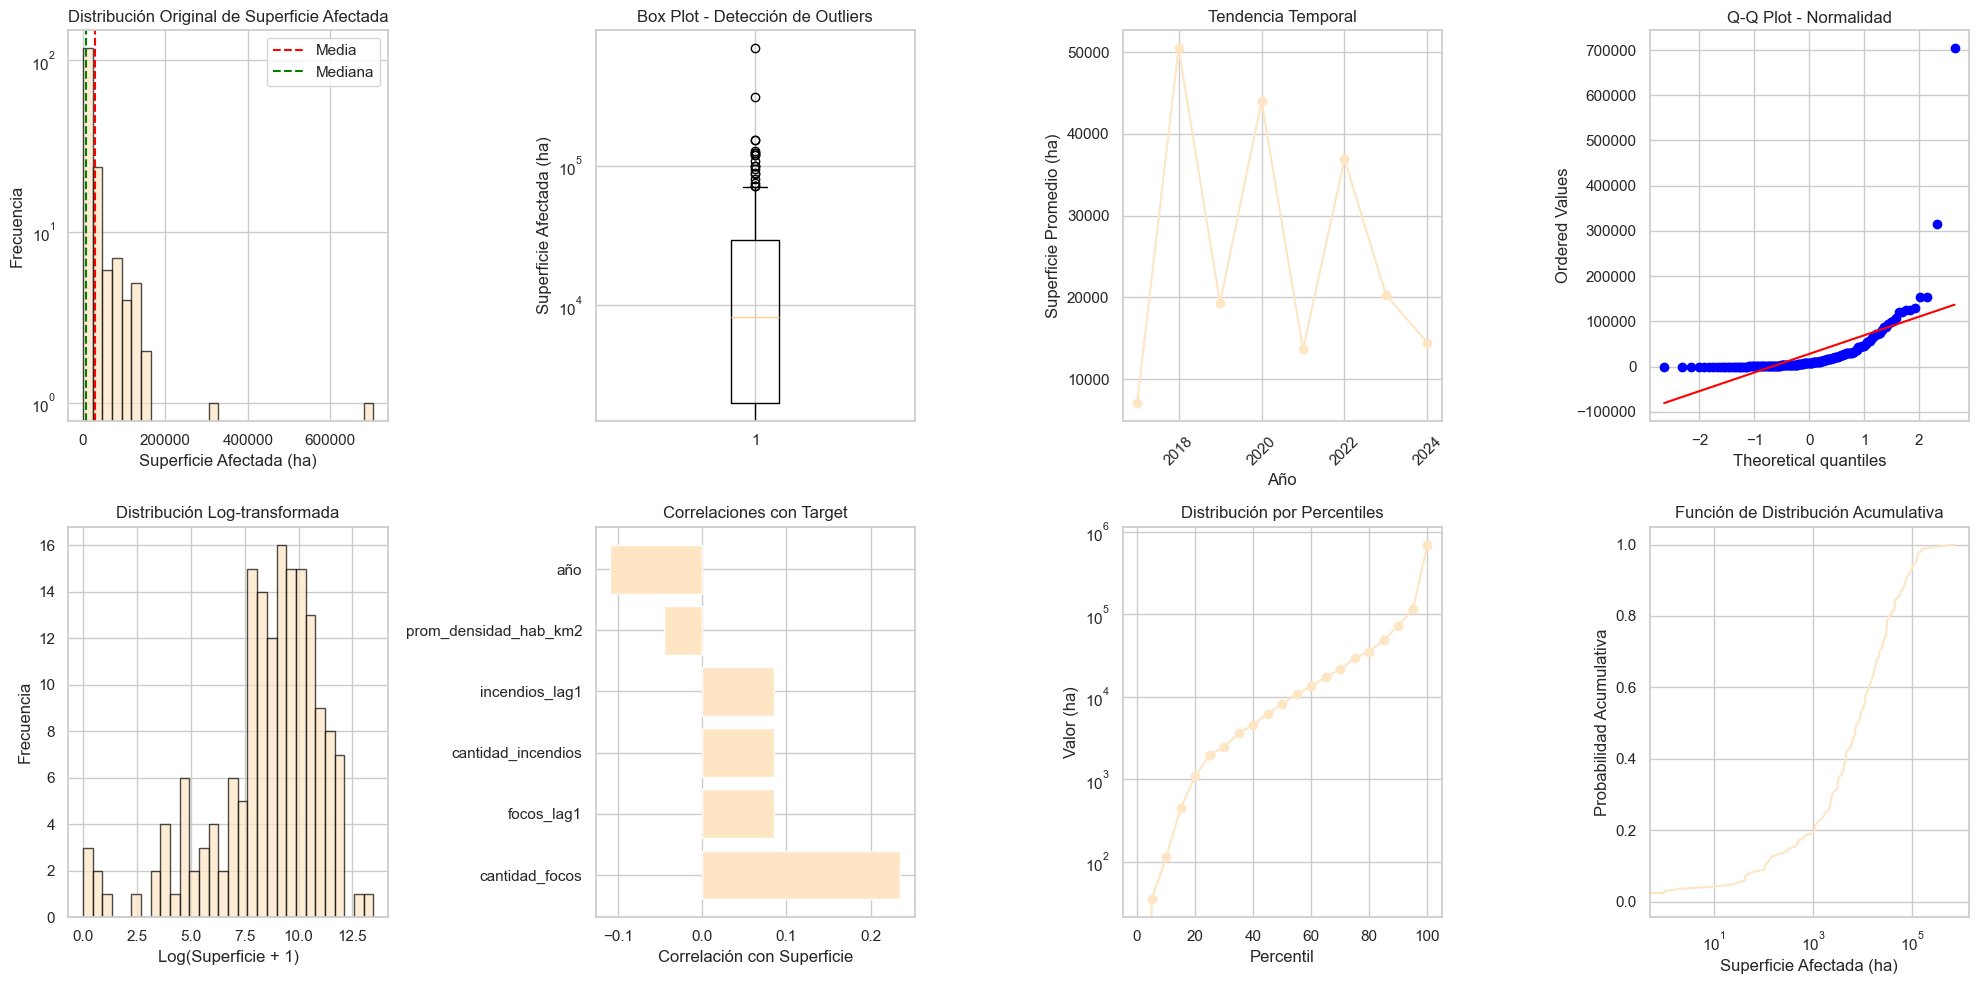

📊 Features seleccionadas: ['cantidad_focos', 'focos_lag1', 'incendios_lag1', 'prom_densidad_hab_km2', 'focos_cambio', 'focos_ratio', 'incendios_focos_ratio', 'densidad_log']
📊 Datos iniciales: 168 muestras, 8 features
📊 División temporal inicial: 167 train, 1 test
📊 Años entrenamiento: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
📊 Años test: [np.int64(2017)]
⚠️  Test set muy pequeño, usando división aleatoria

🔄 APLICANDO SMOTE-R AL CONJUNTO DE ENTRENAMIENTO

🔄 APLICANDO SMOTE-R - MÉTODO: EXTREMOS
📊 Datos originales: 134 muestras

📈 DISTRIBUCIÓN ORIGINAL:
• Q25: 1653.50, Q50: 8476.00, Q75: 28704.00
• Q90: 71514.66, Q95: 103332.10, Q99: 262165.15
🎯 MÉTODO EXTREMOS:
• Valores raros bajos: < 119.00
• Valores raros altos: > 71514.66
🔍 Valores raros detectados: 28
🧠 Usando k = 5 para SMOGN


r_index: 100%|##########| 5/5 [00:00<00:00, 866.20it/s]

sali if
✅ SMOTE-R aplicado exitosamente
📊 Datos después de SMOTE-R: 196 muestras
📈 Incremento: 62 muestras sintéticas

📈 DISTRIBUCIÓN DESPUÉS DE SMOTE-R:
• Q25: 6832.25, Q50: 42215.87, Q75: 73589.36
• Q90: 121036.79, Q95: 143651.53, Q99: 704183.11

📊 COMPARACIÓN DE DISTRIBUCIONES:
• Media original: 28291.36 → Nueva: 63536.73
• Std original: 71061.38 → Nueva: 108339.27
• Skewness original: 7.19 → Nueva: 4.53


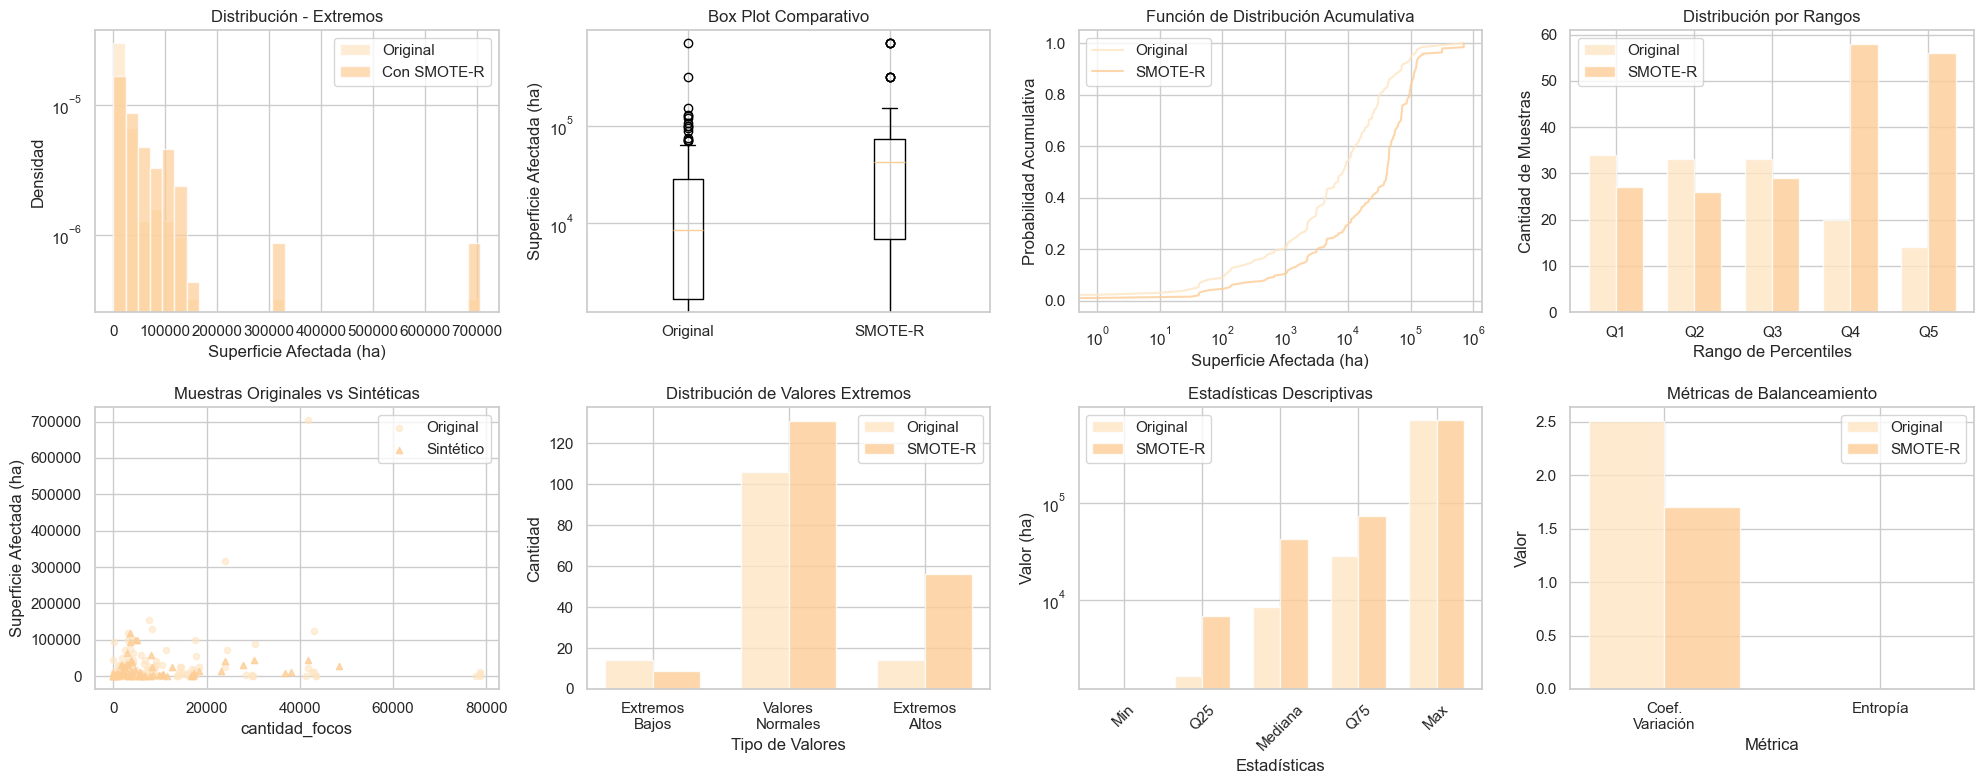

✅ SMOTE-R aplicado. Nuevos datos de entrenamiento: 196 muestras
📊 Aplicando transformación logarítmica al target (distribución asimétrica)

🤖 CONFIGURACIÓN DEL MODELO:
• n_estimators: 40
• max_depth: 6
• learning_rate: 0.1
• subsample: 0.8
• colsample_bytree: 0.8
• reg_alpha: 0.1
• reg_lambda: 0.1
• random_state: 42

📊 MÉTRICAS DEL MODELO:
Métrica         Entrenamiento   Test           
--------------------------------------------------
MSE             956058131.73    1058728446.33  
MAE             13053.76        20226.84       
RMSE            30920.19        32538.11       
R²              0.9181          0.3457         

🎯 MÉTRICAS ESPECÍFICAS PARA VALORES EXTREMOS:
• Valores Altos (>85052.1): MAE=61484.64, R²=-7.2111, n=4
• Valores Bajos (<215.7): MAE=4797.85, R²=-23144.8529, n=4

⚠️  POSIBLE SOBREAJUSTE DETECTADO
   Diferencia significativa entre R² de entrenamiento y test

🎯 VALIDACIÓN CRUZADA (R²):
   Media: -3.0668 ± 5.1297
   Rango: [-12.9054, 0.3815]

🎯 IMPORTANCIA DE VARIA

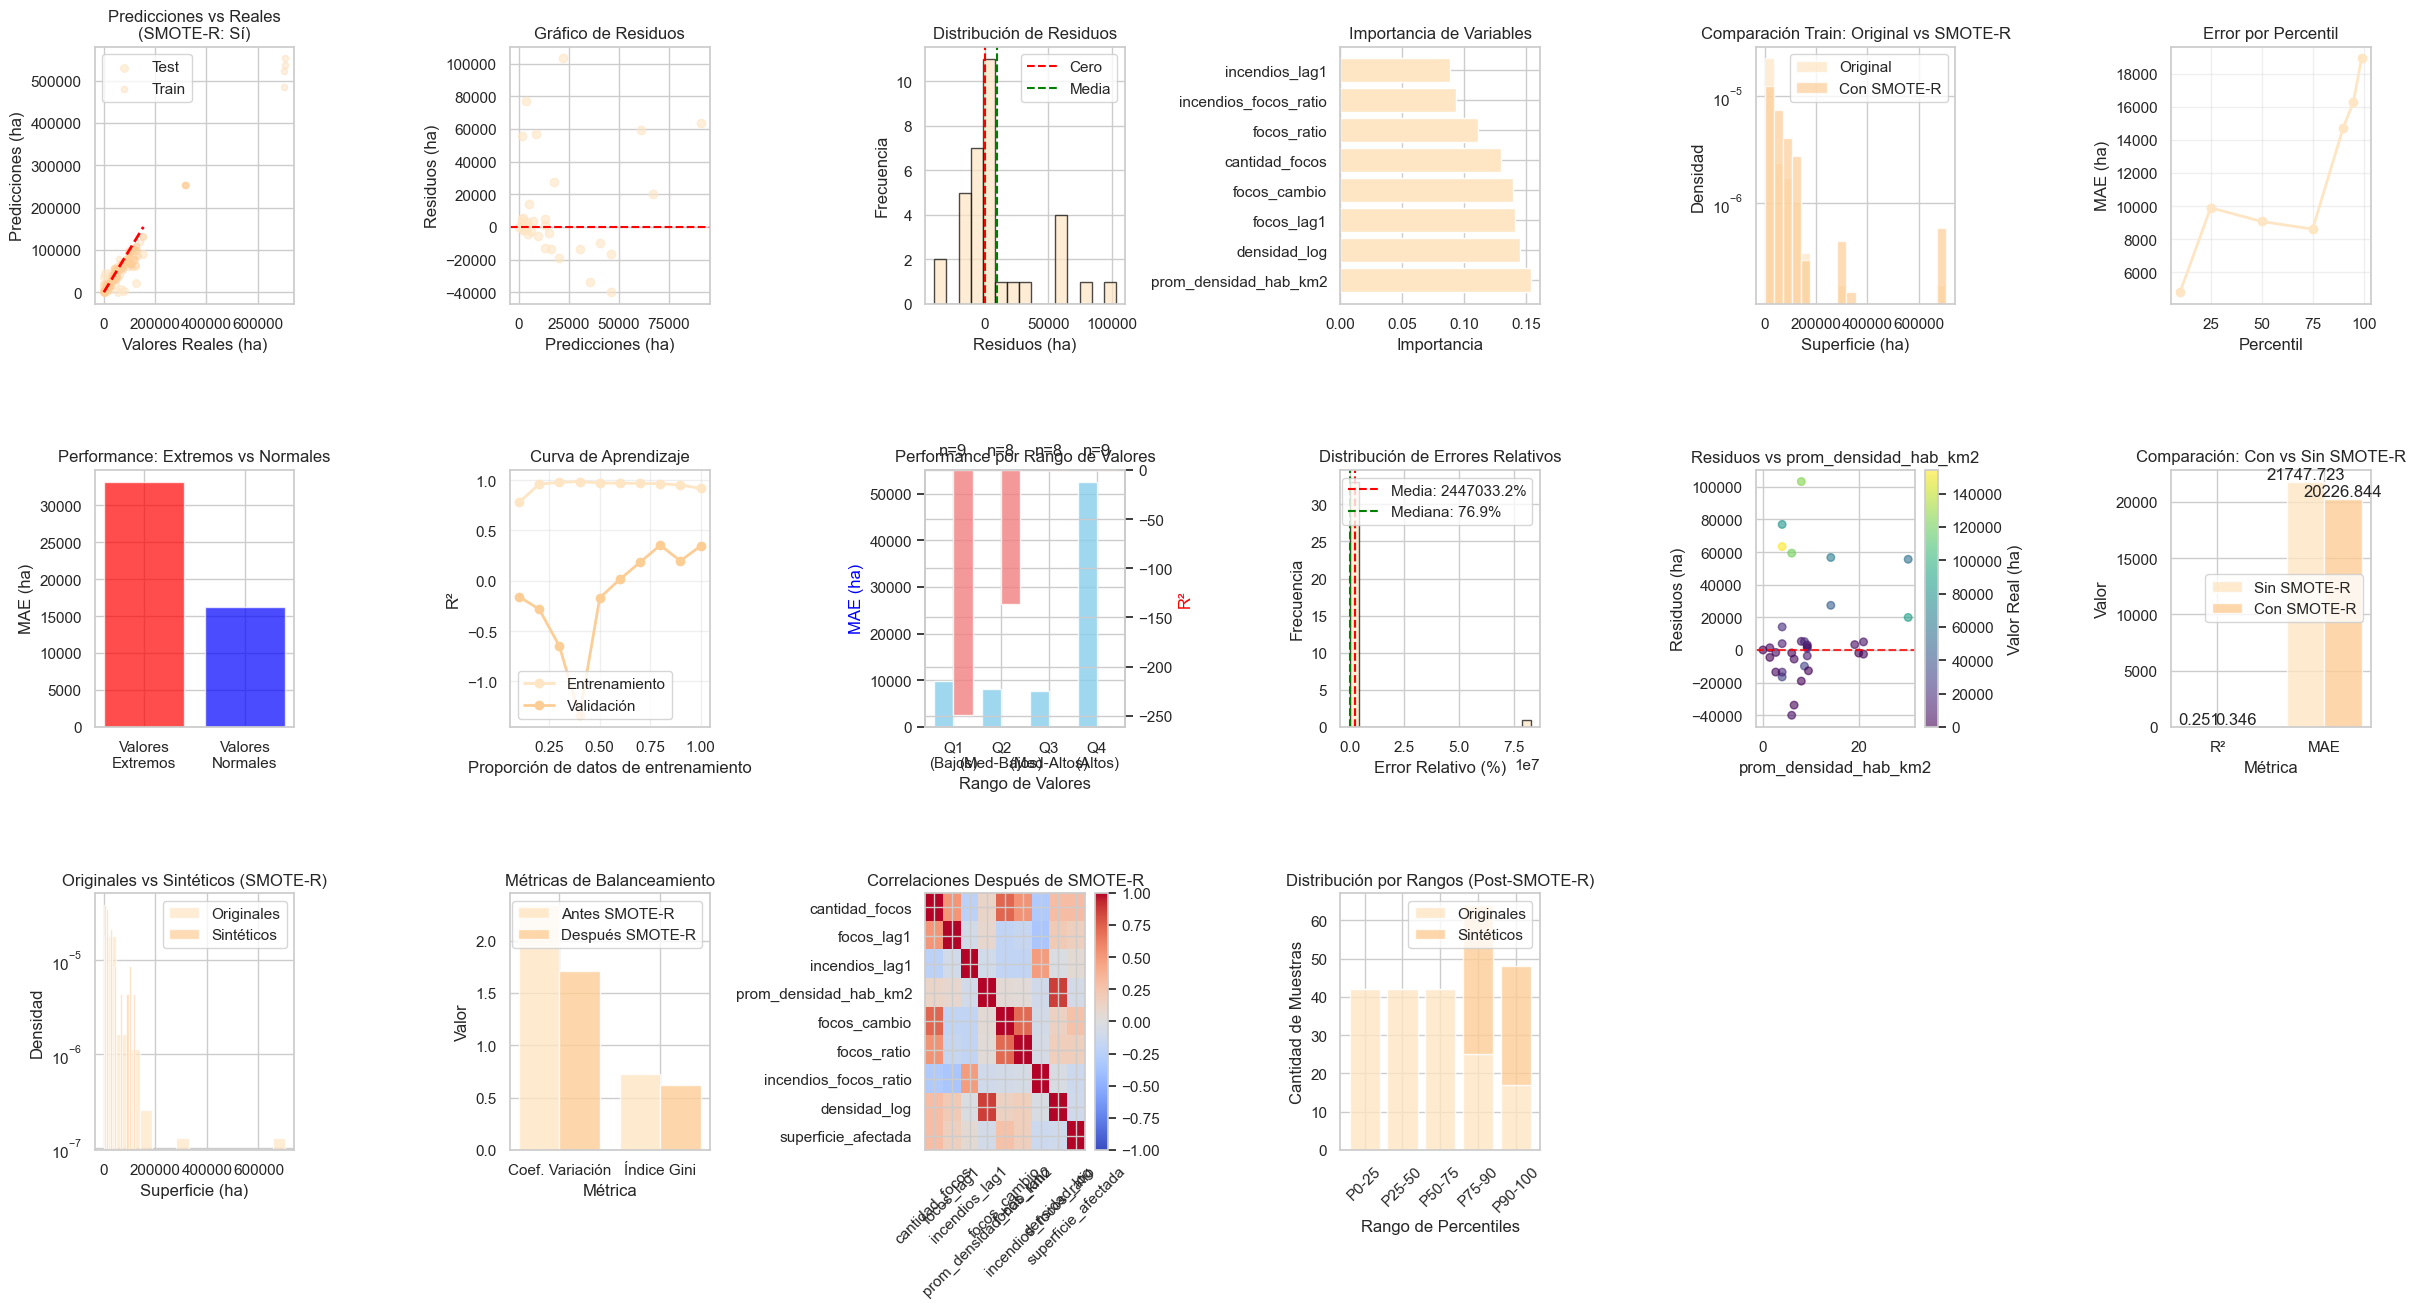


📊 RESUMEN FINAL DEL MODELO
• SMOTE-R aplicado: ✅ SÍ
• Método SMOTE-R: EXTREMOS
• Muestras agregadas: 29
• Incremento: 17.4%
• Transformación log: ✅ SÍ
• R² Test: 0.3457
• MAE Test: 20226.84 ha
• RMSE Test: 32538.11 ha
• 🎯 MEJORA SIGNIFICATIVA con SMOTE-R: +0.0944 en R²


In [36]:

# Entrenar modelo 2
modelo_xgb, importancia_xgb, residuos = entrenar_xgboost(df_ml)

### Conclusiones Modelo 2 
* Como el modelo regresivo no predice correctamente R^2 bajo, debido a la falta de buenos datos. Se aplica un modelo de clasificacion binaria; Prediccion de grandes incendios

In [37]:
# Definir umbral para clasificación binaria
umbral = 1000  # ajusta según criterio o distribución de datos

df_ml['target_binaria'] = (df_ml['superficie_afectada'] > umbral).astype(int)


In [38]:
target_bin = 'target_binaria'
features = df_ml.drop(columns=["jurisdicción", "año", "superficie_afectada", target_bin]).select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

train = df_ml[df_ml["año"] < 2019]
test = df_ml[df_ml["año"] >= 2019]

X_train = train[features]
y_train = train[target_bin]
X_test = test[features]
y_test = test[target_bin]

# Eliminar registros con NaN en X o y
train_mask = y_train.notna() & X_train.notna().all(axis=1)
X_train = X_train[train_mask]
y_train = y_train[train_mask]

test_mask = y_test.notna() & X_test.notna().all(axis=1)
X_test = X_test[test_mask]
y_test = y_test[test_mask]


In [39]:
os.environ["SCIPY_ARRAY_API"] = "0"
smote = SMOTE(random_state=42, k_neighbors=4)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [40]:

xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_bal, y_train_bal)

y_pred = xgb_clf.predict(X_test)


              precision    recall  f1-score   support

           0       0.16      0.19      0.18        26
           1       0.81      0.78      0.80       118

    accuracy                           0.67       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.70      0.67      0.68       144



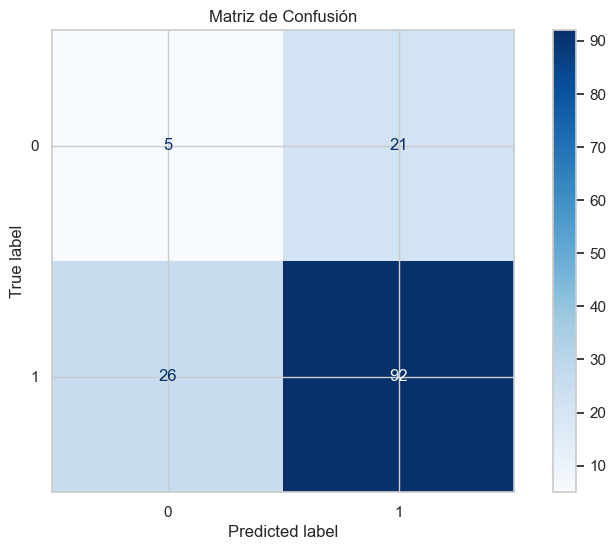

In [41]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()



🔎 Umbral: 0.10
              precision    recall  f1-score   support

           0       0.33      0.12      0.17        26
           1       0.83      0.95      0.89       118

    accuracy                           0.80       144
   macro avg       0.58      0.53      0.53       144
weighted avg       0.74      0.80      0.76       144



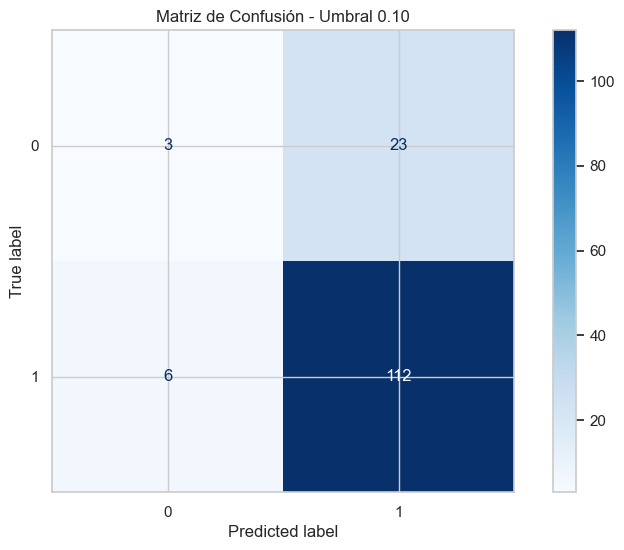


🔎 Umbral: 0.20
              precision    recall  f1-score   support

           0       0.18      0.12      0.14        26
           1       0.82      0.88      0.85       118

    accuracy                           0.74       144
   macro avg       0.50      0.50      0.49       144
weighted avg       0.70      0.74      0.72       144



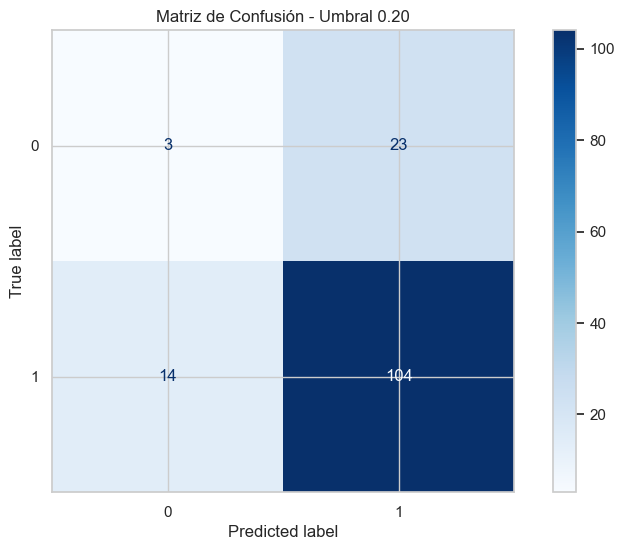


🔎 Umbral: 0.30
              precision    recall  f1-score   support

           0       0.20      0.15      0.17        26
           1       0.82      0.86      0.84       118

    accuracy                           0.74       144
   macro avg       0.51      0.51      0.51       144
weighted avg       0.71      0.74      0.72       144



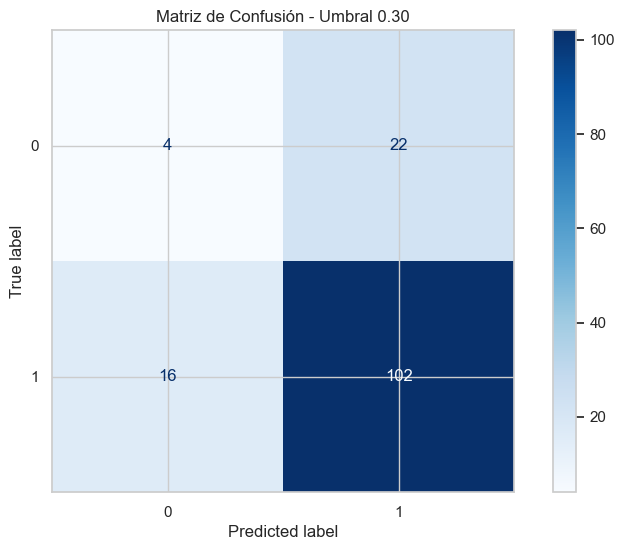


🔎 Umbral: 0.40
              precision    recall  f1-score   support

           0       0.21      0.19      0.20        26
           1       0.82      0.84      0.83       118

    accuracy                           0.72       144
   macro avg       0.52      0.52      0.52       144
weighted avg       0.71      0.72      0.72       144



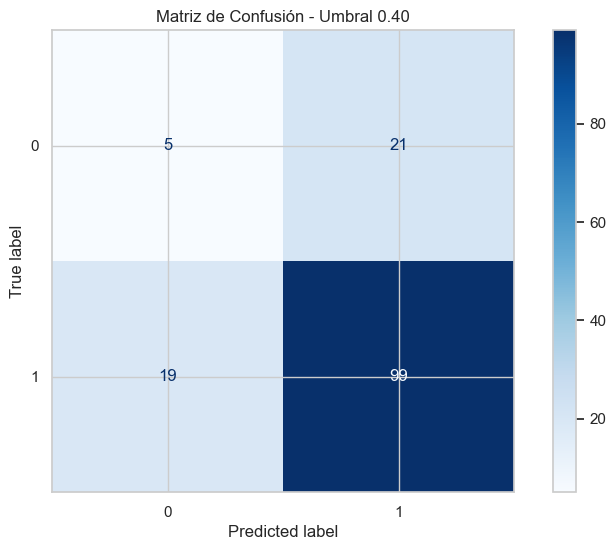


🔎 Umbral: 0.50
              precision    recall  f1-score   support

           0       0.16      0.19      0.18        26
           1       0.81      0.78      0.80       118

    accuracy                           0.67       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.70      0.67      0.68       144



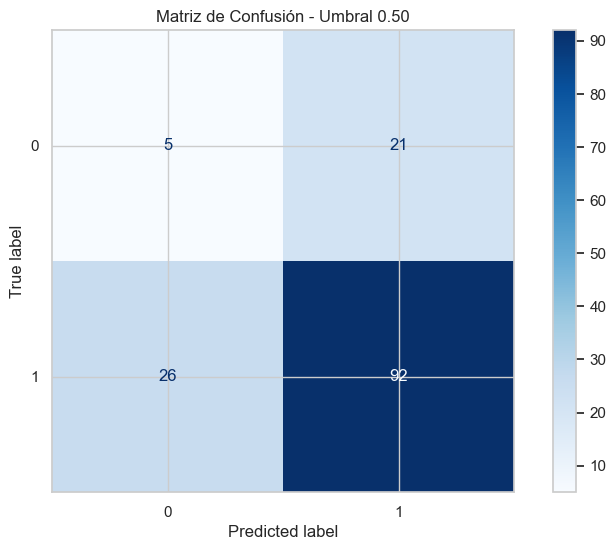


🔎 Umbral: 0.60
              precision    recall  f1-score   support

           0       0.17      0.23      0.20        26
           1       0.82      0.75      0.78       118

    accuracy                           0.66       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.70      0.66      0.68       144



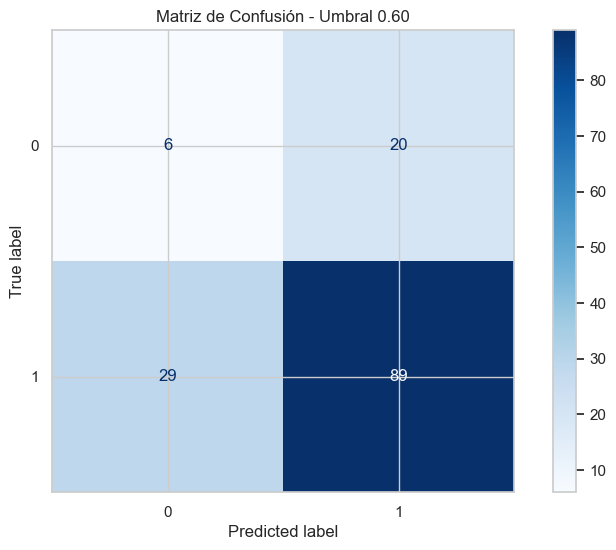


🔎 Umbral: 0.70
              precision    recall  f1-score   support

           0       0.17      0.31      0.22        26
           1       0.82      0.68      0.74       118

    accuracy                           0.61       144
   macro avg       0.50      0.49      0.48       144
weighted avg       0.70      0.61      0.65       144



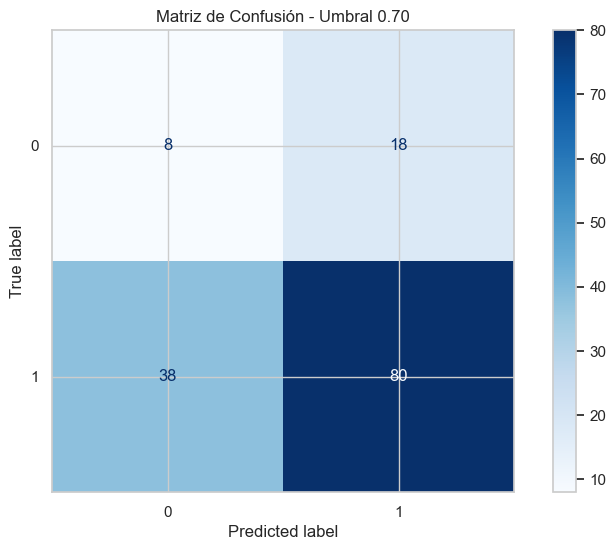


🔎 Umbral: 0.80
              precision    recall  f1-score   support

           0       0.18      0.42      0.25        26
           1       0.82      0.57      0.67       118

    accuracy                           0.54       144
   macro avg       0.50      0.50      0.46       144
weighted avg       0.70      0.54      0.59       144



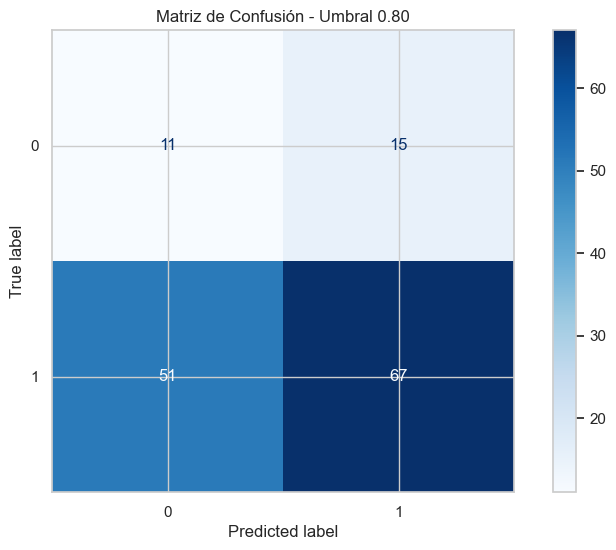

ROC-AUC: 0.5912646675358539


In [42]:

# 1. Entrenamiento del modelo
scale_pos_weight = y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1]

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Aunque SMOTE balancea, esto ayuda si hay desbalance residual
    random_state=42
)

xgb.fit(X_train_bal, y_train_bal)

# 2. Predicción de probabilidades
y_probs = xgb.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

# 3. Evaluación con múltiples umbrales
thresholds = np.arange(0.1, 0.9, 0.1)

for thresh in thresholds:
    y_pred_thresh = (y_probs > thresh).astype(int)
    print(f"\n🔎 Umbral: {thresh:.2f}")
    print(classification_report(y_test, y_pred_thresh, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_thresh)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - Umbral {thresh:.2f}")
    plt.show()


y_pred_proba = xgb_clf.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

### Se puede ajustar el umbral, para predecir incendios que no son grandes, pero a cambio se pierde +20% de precision en la prediccion de grandes incendios, debido al desbalance extremo de los datos


* El modelo clasifica bien, un valor de ROC-AUC 0.59 indica que el modelo apenas esta por encima del azar, a pesar de tener accuracy de 0.67, esta muy sesgado hacia la clase 1 (como se ve en el heatmap).
* Causas Posibles:
    * Features poco informativos: El modelo puede estar sobreajustando a ruido de variables menos relevantes
    * Smote generando puntos poco realistas: Smote falla, si tiene clases muy solapadas, variables no linealmente separables, el espacio generado no respeta restricciones naturales (ej: valores negativos que no tienen sentido)

### Posibles mejoras

In [43]:

scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='roc_auc')
print("ROC-AUC promedio (5 folds):", scores.mean())


ROC-AUC promedio (5 folds): 0.5


In [44]:

sm = SMOTE(random_state=42, k_neighbors=4)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

xgb.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:


param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train_res, y_train_res)

print("Mejor AUC:", grid.best_score_)
print("Mejores parámetros:", grid.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejor AUC: 0.8666666666666666
Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


Con las mejoras, se encontro, que el modelo puede funcionar mejor, si le aplica otra configuracion

In [46]:
best_model = XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.7,
    random_state=42
)

best_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

ROC-AUC en test: 0.6383637548891786
              precision    recall  f1-score   support

           0       0.21      0.31      0.25        26
           1       0.83      0.75      0.79       118

    accuracy                           0.67       144
   macro avg       0.52      0.53      0.52       144
weighted avg       0.72      0.67      0.69       144



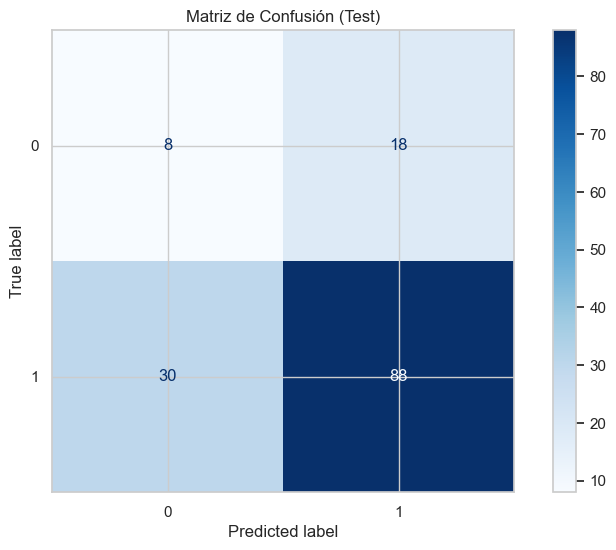

In [47]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("ROC-AUC en test:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Matriz de Confusión (Test)")
plt.show()

Conclusion: Si bien el modelo mejoro gracias a la optimizacion de hiperparametros, la naturaleza desbalanceada del test set limita el desempeño final. Smote solo afecta al entrenamiento, no al test, por lo que el desbalance en y_test persiste y sesga los resultados.
El modelo tiene potencial (ROC-UAC > 0.63), pero requiere trabajo sobre la clase 0 para que sea util

### Mejoras sugeridas:
* Ajustar el umbral de decision para mejorar el f1-recall en clase 0.
* Evaluar con PR-AUC, ya que es mas informativo en datasets desbalanceados.
* Entrenar y evaluar con LightGBM, es mas rapido y tiene mejor manejo del desbalance

⚠️ Advertencia sobre el uso de XGBoost
El modelo XGBoost se mantuvo como regresor principal debido a su capacidad para capturar relaciones no lineales complejas entre variables. Sin embargo, se advierte que el conjunto de datos disponible contiene únicamente 120 muestras, lo cual es un volumen moderado que puede no ser suficiente para que este tipo de modelo exprese todo su potencial sin incurrir en sobreajuste.

Por esta razón, los resultados obtenidos deben interpretarse con cautela. En contextos con datos limitados, modelos más simples (como regresores lineales o de árboles menos profundos) pueden ofrecer un mejor compromiso entre sesgo y varianza. Se recomienda complementar este enfoque con validación cruzada robusta y, en lo posible, incrementar la base de datos para futuras versiones del modelo.

# Modelo 3
### Prophet


In [48]:
# %% [markdown]
# ## 5. MODELO 3: PROPHET - TENDENCIAS MENSUALES

# %%
def preparar_datos_prophet(df, target_col='cantidad_incendios'):
    """
    Prepara datos para Prophet (requiere datos mensuales)
    """
    print("📅 PREPARANDO DATOS PARA PROPHET")
    
    # Si no tienes datos mensuales, simularemos expandiendo los anuales
    if 'mes' not in df.columns:
        print("⚠️  No se encontraron datos mensuales. Expandiendo datos anuales...")
        
        df_mensual = []
        for _, row in df.iterrows():
            for mes in range(1, 13):
                fecha = pd.to_datetime(f"{int(row['año'])}-{mes:02d}-01")
                # Dividir valores anuales entre 12 meses (simplificación)
                valor_mensual = row[target_col] / 12 if pd.notnull(row[target_col]) else 0
                
                df_mensual.append({
                    'ds': fecha,
                    'y': valor_mensual,
                    'jurisdiccion': row['jurisdicción']
                })
        
        df_prophet = pd.DataFrame(df_mensual)
    else:
        # Si ya tienes datos mensuales
        df_prophet = df.copy()
        df_prophet['ds'] = pd.to_datetime(df_prophet[['año', 'mes']].assign(day=1))
        df_prophet['y'] = df_prophet[target_col]
    
    print(f"📊 Datos preparados: {len(df_prophet)} registros mensuales")
    print(f"Rango de fechas: {df_prophet['ds'].min()} a {df_prophet['ds'].max()}")
    
    return df_prophet


In [49]:
#%%
def entrenar_prophet_por_jurisdiccion(df_prophet, jurisdiccion_ejemplo=None):
    """
    Entrena modelo Prophet para una jurisdicción específica
    """
    print("🔮 ENTRENANDO PROPHET - SERIES TEMPORALES")
    
    # Seleccionar jurisdicción ejemplo
    if jurisdiccion_ejemplo is None:
        jurisdiccion_ejemplo = df_prophet['jurisdiccion'].value_counts().index[16]
    
    print(f"📍 Entrenando para jurisdicción: {jurisdiccion_ejemplo}")
    
    # Filtrar datos
    datos_jurisdiccion = df_prophet[df_prophet['jurisdiccion'] == jurisdiccion_ejemplo].copy()
    datos_jurisdiccion = datos_jurisdiccion[['ds', 'y']].reset_index(drop=True)
    
    # Asegurar que no hay valores nulos
    datos_jurisdiccion['y'] = datos_jurisdiccion['y'].fillna(0)
    
    print(f"📊 Registros para entrenamiento: {len(datos_jurisdiccion)}")
    
    # Entrenar Prophet
    modelo_prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05
    )
    
    modelo_prophet.fit(datos_jurisdiccion)
    
    # Crear fechas futuras (próximos 12 meses)
    future = modelo_prophet.make_future_dataframe(periods=12, freq='M')
    forecast = modelo_prophet.predict(future)
    
    # Métricas básicas (últimos 12 meses como test)
    if len(datos_jurisdiccion) >= 24:  # Al menos 2 años de datos
        train_size = len(datos_jurisdiccion) - 12
        train_data = datos_jurisdiccion[:train_size]
        test_data = datos_jurisdiccion[train_size:]
        
        # Re-entrenar con datos de entrenamiento
        modelo_test = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )
        modelo_test.fit(train_data)
        
        # Predecir período de test
        future_test = modelo_test.make_future_dataframe(periods=12, freq='M')
        forecast_test = modelo_test.predict(future_test)
        
        # Calcular métricas
        y_true = test_data['y'].values
        y_pred = forecast_test['yhat'][-12:].values
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        
        print(f"\n📊 MÉTRICAS DE VALIDACIÓN:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {np.sqrt(mse):.4f}")
    
    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Subplot 1: Serie temporal y predicción
    ax1 = axes[0, 0]
    modelo_prophet.plot(forecast, ax=ax1)
    ax1.set_title(f'Predicción Prophet - {jurisdiccion_ejemplo}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Cantidad')
    
    # Subplot 2: Componentes
    ax2 = axes[0, 1]
    componentes = modelo_prophet.predict(future)
    ax2.plot(componentes['ds'], componentes['trend'], label='Tendencia')
    ax2.plot(componentes['ds'], componentes['yearly'], label='Estacionalidad')
    ax2.set_title('Componentes del Modelo')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Subplot 3: Predicciones futuras
    ax3 = axes[1, 0]
    futuro = forecast.tail(12)
    ax3.plot(futuro['ds'], futuro['yhat'], marker='o', label='Predicción')
    ax3.fill_between(futuro['ds'], futuro['yhat_lower'], futuro['yhat_upper'], 
                     alpha=0.3, label='Intervalo de confianza')
    ax3.set_title('Predicciones Próximos 12 Meses')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)
    
    # Subplot 4: Distribución de valores
    ax4 = axes[1, 1]
    ax4.hist(datos_jurisdiccion['y'], bins=20, alpha=0.6, label='Histórico')
    ax4.axvline(forecast['yhat'].mean(), color='red', linestyle='--', label='Predicción promedio')
    ax4.set_title('Distribución de Valores')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Resumen de predicciones
    print(f"\n🔮 PREDICCIONES PRÓXIMOS 12 MESES:")
    predicciones_futuras = forecast.tail(12)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    predicciones_futuras['ds'] = predicciones_futuras['ds'].dt.strftime('%Y-%m')
    print(predicciones_futuras.round(2))
    
    return modelo_prophet, forecast, predicciones_futuras

📅 PREPARANDO DATOS PARA PROPHET
⚠️  No se encontraron datos mensuales. Expandiendo datos anuales...
📊 Datos preparados: 2088 registros mensuales
Rango de fechas: 2017-01-01 00:00:00 a 2024-12-01 00:00:00
🔮 ENTRENANDO PROPHET - SERIES TEMPORALES
📍 Entrenando para jurisdicción: río negro
📊 Registros para entrenamiento: 84


18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing



📊 MÉTRICAS DE VALIDACIÓN:
MAE: 8.3799
RMSE: 8.9148


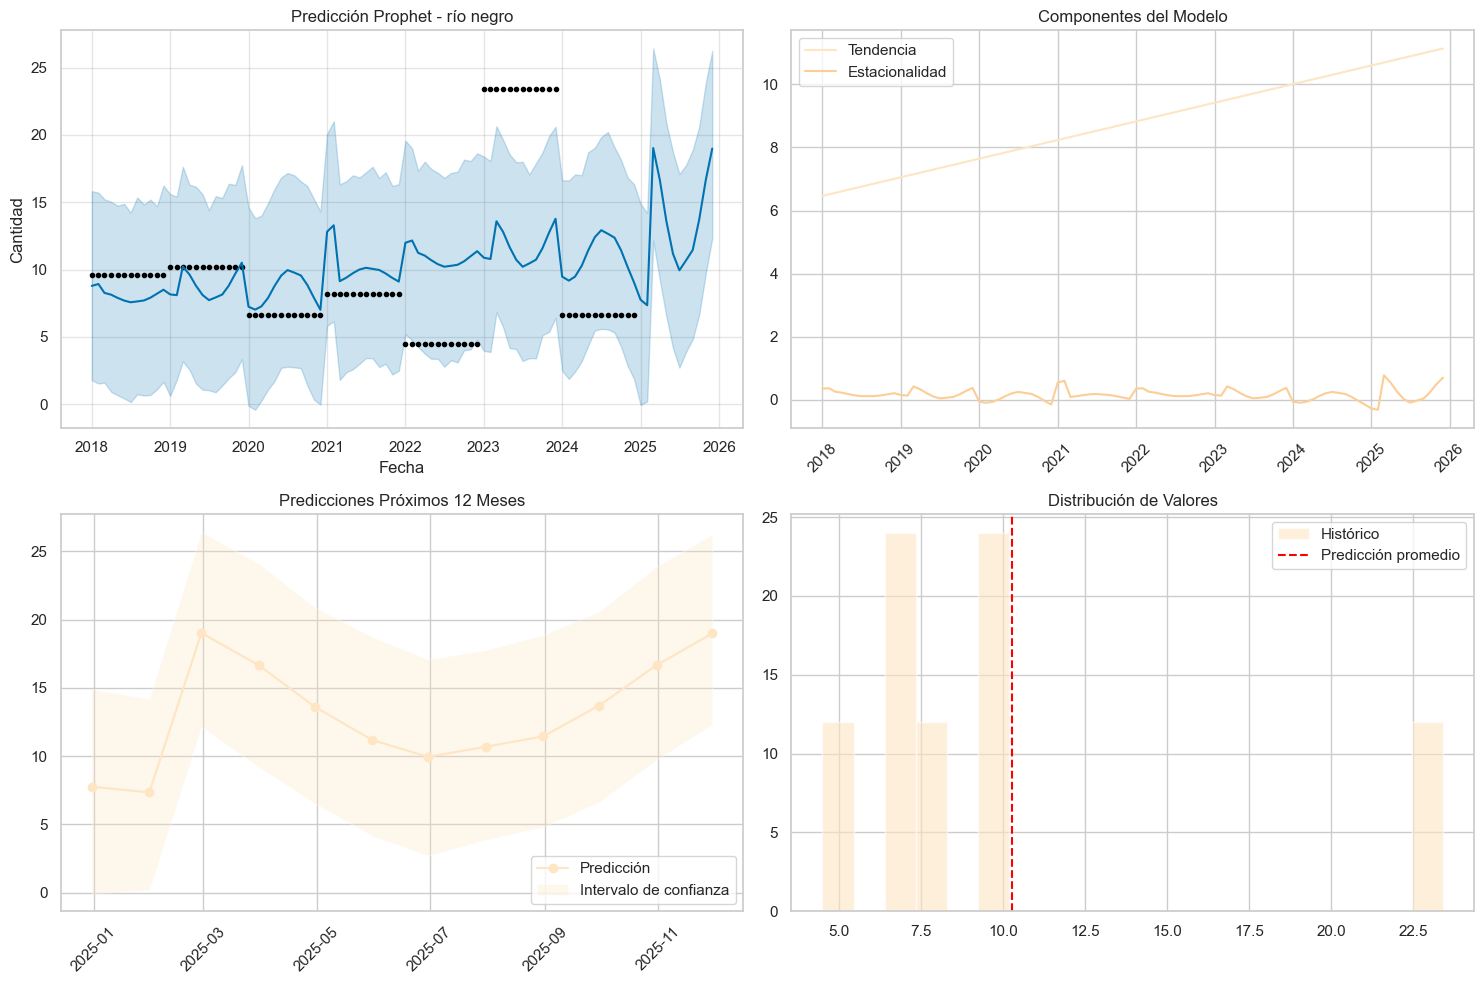


🔮 PREDICCIONES PRÓXIMOS 12 MESES:
         ds   yhat  yhat_lower  yhat_upper
84  2024-12   7.76       -0.05       14.89
85  2025-01   7.34        0.19       14.19
86  2025-02  19.03       12.15       26.43
87  2025-03  16.64        9.19       24.09
88  2025-04  13.62        6.55       20.90
89  2025-05  11.17        4.16       18.74
90  2025-06   9.94        2.71       17.10
91  2025-07  10.68        3.87       17.76
92  2025-08  11.45        4.82       18.88
93  2025-09  13.69        6.63       20.58
94  2025-10  16.66        9.73       23.88
95  2025-11  18.99       12.32       26.24


In [50]:
# Preparar datos y entrenar Prophet
df_prophet = preparar_datos_prophet(df_ml, 'cantidad_incendios')
modelo_prophet, forecast_prophet, predicciones_futuras = entrenar_prophet_por_jurisdiccion(df_prophet)


# Resumen

In [51]:

# %% [markdown]
# ## 6. COMPARACIÓN Y RESUMEN DE MODELOS

# %%
def resumen_modelos():
    """
    Genera un resumen comparativo de los tres modelos
    """
    print("📊 RESUMEN COMPARATIVO DE MODELOS")
    print("=" * 60)
    
    resumen = {
        'Modelo': ['Random Forest (Clasificación)', 'XGBoost (Regresión)', 'Prophet (Series Temporales)'],
        'Objetivo': ['Clasificar riesgo de incendios', 'Predecir superficie afectada', 'Tendencias mensuales'],
        'Tipo': ['Clasificación', 'Regresión', 'Forecasting'],
        'Variables_Principales': [
            'Focos, Incendios lag, Densidad población',
            'Focos, Incendios, Superficie histórica',
            'Serie temporal de incendios'
        ]
    }
    
    df_resumen = pd.DataFrame(resumen)
    print(df_resumen.to_string(index=False))
    
    print("\n🎯 CASOS DE USO:")
    print("• Random Forest: Alertas tempranas de riesgo por región")
    print("• XGBoost: Estimación de daños potenciales")
    print("• Prophet: Planificación de recursos y tendencias estacionales")
    
    print("\n💡 RECOMENDACIONES:")
    print("• Combinar los tres modelos para un sistema integral")
    print("• Actualizar modelos regularmente con nuevos datos")
    print("• Considerar variables meteorológicas adicionales")
    print("• Validar con datos de diferentes regiones climáticas")


In [52]:
resumen_modelos()

📊 RESUMEN COMPARATIVO DE MODELOS
                       Modelo                       Objetivo          Tipo                    Variables_Principales
Random Forest (Clasificación) Clasificar riesgo de incendios Clasificación Focos, Incendios lag, Densidad población
          XGBoost (Regresión)   Predecir superficie afectada     Regresión   Focos, Incendios, Superficie histórica
  Prophet (Series Temporales)           Tendencias mensuales   Forecasting              Serie temporal de incendios

🎯 CASOS DE USO:
• Random Forest: Alertas tempranas de riesgo por región
• XGBoost: Estimación de daños potenciales
• Prophet: Planificación de recursos y tendencias estacionales

💡 RECOMENDACIONES:
• Combinar los tres modelos para un sistema integral
• Actualizar modelos regularmente con nuevos datos
• Considerar variables meteorológicas adicionales
• Validar con datos de diferentes regiones climáticas


# Prediccion Con Nuevos Datos

In [53]:

# %% [markdown]
# ## 7. FUNCIONES DE PREDICCIÓN PARA NUEVOS DATOS

# %%
def predecir_nuevos_datos(focos_actual, focos_lag, incendios_lag, densidad_pob):
    """
    Función para hacer predicciones con los modelos entrenados
    """
    print("🔮 REALIZANDO PREDICCIONES CON NUEVOS DATOS")
    print("=" * 50)
    
    # Preparar datos de entrada
    nuevos_datos = pd.DataFrame({
        'cantidad_focos': [focos_actual],
        'focos_lag1': [focos_lag],
        'incendios_lag1': [incendios_lag],
        'prom_densidad_hab_km2': [densidad_pob]
    })
    
    print(f"📊 Datos de entrada:")
    print(f"• Focos actuales: {focos_actual}")
    print(f"• Focos año anterior: {focos_lag}")
    print(f"• Incendios año anterior: {incendios_lag}")
    print(f"• Densidad población: {densidad_pob} hab/km²")
    
    resultados = {}
    
    # Modelo 1: Random Forest (Clasificación)
    if 'modelo_rf' in globals():
        riesgo_pred = modelo_rf.predict(nuevos_datos)[0]
        riesgo_categoria = label_encoder.inverse_transform([riesgo_pred])[0]
        probabilidades = modelo_rf.predict_proba(nuevos_datos)[0]
        
        resultados['Random Forest'] = {
            'Predicción': f'Riesgo {riesgo_categoria}',
            'Probabilidades': dict(zip(label_encoder.classes_, probabilidades))
        }
        
        print(f"\n🌲 RANDOM FOREST:")
        print(f"   Riesgo predicho: {riesgo_categoria}")
        print(f"   Probabilidades: {dict(zip(label_encoder.classes_, probabilidades.round(3)))}")
    
    # Modelo 2: XGBoost (Regresión)
    if 'modelo_xgb' in globals() and modelo_xgb is not None:
        # Agregar columna de incendios actuales (estimada)
        nuevos_datos_xgb = nuevos_datos.copy()
        if 'cantidad_incendios' in modelo_xgb.feature_names_in_:
            nuevos_datos_xgb['cantidad_incendios'] = incendios_lag * 1.1  # Estimación simple
        
        # Asegurar que tenemos todas las columnas necesarias
        for col in modelo_xgb.feature_names_in_:
            if col not in nuevos_datos_xgb.columns:
                nuevos_datos_xgb[col] = 0
        
        superficie_pred = modelo_xgb.predict(nuevos_datos_xgb[modelo_xgb.feature_names_in_])[0]
        
        resultados['XGBoost'] = {
            'Predicción': f'{superficie_pred:.2f} hectáreas',
            'Interpretación': 'alta' if superficie_pred > df_ml['superficie_afectada'].quantile(0.75) else 'media' if superficie_pred > df_ml['superficie_afectada'].quantile(0.25) else 'baja'
        }
        
        print(f"\n🚀 XGBOOST:")
        print(f"   Superficie predicha: {superficie_pred:.2f} hectáreas")
        print(f"   Nivel de impacto: {resultados['XGBoost']['Interpretación']}")
    
    print(f"\n📋 RESUMEN DE PREDICCIONES:")
    for modelo, resultado in resultados.items():
        print(f"• {modelo}: {resultado['Predicción']}")
    
    return resultados

In [54]:
# Ejemplo de uso
ejemplo_prediccion = predecir_nuevos_datos(
    focos_actual=50,
    focos_lag=45,
    incendios_lag=12,
    densidad_pob=15.5
)

🔮 REALIZANDO PREDICCIONES CON NUEVOS DATOS
📊 Datos de entrada:
• Focos actuales: 50
• Focos año anterior: 45
• Incendios año anterior: 12
• Densidad población: 15.5 hab/km²

🌲 RANDOM FOREST:
   Riesgo predicho: Bajo
   Probabilidades: {'Alto': np.float64(0.02), 'Bajo': np.float64(0.94), 'Medio': np.float64(0.04)}

🚀 XGBOOST:
   Superficie predicha: 9.50 hectáreas
   Nivel de impacto: baja

📋 RESUMEN DE PREDICCIONES:
• Random Forest: Riesgo Bajo
• XGBoost: 9.50 hectáreas


In [55]:
print("\n✅ NOTEBOOK COMPLETADO")
print("📌 Los modelos están listos para usar con nuevos datos")
print("📌 Considera guardar los modelos entrenados para uso futuro:")
print("   - joblib.dump(modelo_rf, 'modelo_random_forest.pkl')")
print("   - modelo_xgb.save_model('modelo_xgboost.json')")
print("   - with open('modelo_prophet.pkl', 'wb') as f: pickle.dump(modelo_prophet, f)")


✅ NOTEBOOK COMPLETADO
📌 Los modelos están listos para usar con nuevos datos
📌 Considera guardar los modelos entrenados para uso futuro:
   - joblib.dump(modelo_rf, 'modelo_random_forest.pkl')
   - modelo_xgb.save_model('modelo_xgboost.json')
   - with open('modelo_prophet.pkl', 'wb') as f: pickle.dump(modelo_prophet, f)
